# Pre-class
`by Svitlana Midianko`
[link](https://course-resources.minerva.kgi.edu/uploaded_files/mke/00185149-8591/pre-class-work.pdf)

In [27]:
# bug I have: there are currently multiuple customers being served at the same time.
# this is because i dont have --  *only if* queue.num_in_queue = 0 --> serve next

## implementing classes 

In [28]:
import scipy.stats as sts
import heapq
import matplotlib.pyplot as plt

In [29]:
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    COPIED FROM PROF CODE. NO CHANGES.
    '''

    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function # !!! will be a function that we want to run when the event is triggered like serving a customer
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)

class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    The `now` attribute contains the time at which the last event was run.
    COPIED FROM PROF CODE. 
    CHANGES: instance attribute groceryStore added to be able to access its method (schedule arrival) in the function
    '''
    
    def __init__(self, groceryStore):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
        self.groceryStore = groceryStore # NEWLY ADDED. Explantion in the function description.
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function,  *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        # Return the time of the next event. The `now` attribute of this class
        # contain the time of the last event that was run.
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        # Print out diagnostic information about the events in the schedule.
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [30]:
class GroceryStore: 
    '''GroceryStore This class contains the queues (in this case only one but you’ll need
    to make more than one for your project). It also schedules the arrival of customers
    at the queue(s).'''
    
    def __init__(self, queue, arrival_dist, service_det_time): 
        # will store all the avalilable queue & 
        # general STORE paramteres, such as arrival dist., service dist. (or deterministic time)
        # as well as any  *output* data that we would like to know about the store, such as data to plot
        self.queue = queue
        self.arrival_distribution = arrival_dist
        self.time_to_serve = service_det_time
        self.plotting_data = {"time" :[], "num_in_queue" : []}
         
    def schedule_arrival(self, schedule): 
        # ARRIVAL OF CUSTIUMER
        # first generate a new arrival time
        next_arrival_time = schedule.now + self.arrival_distribution.rvs()
        # next create an event for the arrival of customer
        customer_arrives_event = Event(next_arrival_time, serve_customer_and_add_new)
        # add this event to the schedule (priority queue implemented as heap) to ensure that this customer is being 
        # served
        schedule.add_event_at(customer_arrives_event.timestamp, customer_arrives_event.function)
        
        # UPDATING GLOBAL PARAMETERS
        self.queue.num_in_queue += 1 
        schedule.now = customer_arrives_event.timestamp
        
        # added so that we can study the dynamics of sim.
        print("[!] NEW customer arrived at: ", schedule.now)
        print("--- NUMBER of customers in queue now: ", self.queue.num_in_queue)

In [31]:
class Queue: 
    '''This class tracks the number of people in the queue and the number of
    people being served. 
    [SUGGESTION FROM PROF WHICH IS NOT IMPLEMENTED: 
    It also schedules when a customer starts being served and
    stops being served (leaves the grocery store).]'''
    
    def __init__(self, num_in_queue = 0, num_served = 0):
        self.num_in_queue = 0
        self.num_served = 0

In [32]:
def serve_customer_and_add_new(schedule):
    '''function that handles serve of the customer. 
    Also, while the customer is served, new customers are arriving and this function
    handles it by accessing _schedule_arrival_ method of the GroceryStore class'''

    fixed_serve_rate = schedule.groceryStore.time_to_serve 
    
    print(f"Customer is being served right now [TIME]: {round(schedule.now, 4)}")

    schedule.now_ = schedule.now # !!! storing current starting time for serve of the current customer 
        # so that we can update an actual current time with newcoming customers
    
    while schedule.now < schedule.now_ + fixed_serve_rate: # while the customer being served, new people are still
        # coming
        schedule.groceryStore.schedule_arrival(schedule)

    print(f"Last customer finished being served right now [TIME]: {schedule.now_ + fixed_serve_rate}")
    schedule.groceryStore.queue.num_in_queue -=1
    
    schedule.groceryStore.plotting_data["time"].append(schedule.now)
    schedule.groceryStore.plotting_data["num_in_queue"].append( schedule.groceryStore.queue.num_in_queue)
    print("-------------------")

In [33]:
def run_simulation(arrival_rate, service_det_time,  run_until):
    ''''main()'' function which generalized all the input parameters we want to have'''
    arrival_distribution = sts.expon(scale=1/arrival_rate) # time between the events 
    queue = Queue(0,0)
    groceryStore = GroceryStore(queue, arrival_distribution, service_det_time)
    schedule = Schedule(groceryStore = groceryStore)
    groceryStore.schedule_arrival(schedule)

    while schedule.next_event_time() <= run_until:
        print('****hello')
        schedule.run_next_event() # popping the customer that arrived the longest time ago
        
    plt.plot(groceryStore.plotting_data["time"],groceryStore.plotting_data["num_in_queue"] )
    plt.legend()
    

## running test  & generating graph

[!] NEW customer arrived at:  0.10251023999510253
--- NUMBER of customers in queue now:  1
****hello
Customer is being served right now [TIME]: 0.1025
[!] NEW customer arrived at:  0.18542091128791394
--- NUMBER of customers in queue now:  2
[!] NEW customer arrived at:  0.24754563834210866
--- NUMBER of customers in queue now:  3
[!] NEW customer arrived at:  0.2608881847274824
--- NUMBER of customers in queue now:  4
[!] NEW customer arrived at:  1.2385789018226976
--- NUMBER of customers in queue now:  5
Last customer finished being served right now [TIME]: 0.3025102399951025
-------------------
****hello
Customer is being served right now [TIME]: 0.1854
[!] NEW customer arrived at:  0.7141621152162417
--- NUMBER of customers in queue now:  5
Last customer finished being served right now [TIME]: 0.38542091128791395
-------------------
****hello
Customer is being served right now [TIME]: 0.2475
[!] NEW customer arrived at:  1.6024674281783082
--- NUMBER of customers in queue now:  5


****hello
Customer is being served right now [TIME]: 2.4343
[!] NEW customer arrived at:  2.7027956242033735
--- NUMBER of customers in queue now:  104
Last customer finished being served right now [TIME]: 2.634337267352766
-------------------
****hello
Customer is being served right now [TIME]: 2.4344
[!] NEW customer arrived at:  3.1243287996385027
--- NUMBER of customers in queue now:  104
Last customer finished being served right now [TIME]: 2.6344354965002164
-------------------
****hello
Customer is being served right now [TIME]: 2.4345
[!] NEW customer arrived at:  2.6610904456314053
--- NUMBER of customers in queue now:  104
Last customer finished being served right now [TIME]: 2.6345285338554234
-------------------
****hello
Customer is being served right now [TIME]: 2.435
[!] NEW customer arrived at:  2.6348945637905805
--- NUMBER of customers in queue now:  104
[!] NEW customer arrived at:  3.111269004515791
--- NUMBER of customers in queue now:  105
Last customer finished b

[!] NEW customer arrived at:  3.2843445398069955
--- NUMBER of customers in queue now:  196
Last customer finished being served right now [TIME]: 3.008578804085086
-------------------
****hello
Customer is being served right now [TIME]: 2.8097
[!] NEW customer arrived at:  2.935271687404848
--- NUMBER of customers in queue now:  196
[!] NEW customer arrived at:  3.266731796345172
--- NUMBER of customers in queue now:  197
Last customer finished being served right now [TIME]: 3.0097209759079244
-------------------
****hello
Customer is being served right now [TIME]: 2.8115
[!] NEW customer arrived at:  2.8428313517454047
--- NUMBER of customers in queue now:  197
[!] NEW customer arrived at:  3.1294810350325815
--- NUMBER of customers in queue now:  198
Last customer finished being served right now [TIME]: 3.01149664368463
-------------------
****hello
Customer is being served right now [TIME]: 2.8124
[!] NEW customer arrived at:  3.0247936043990453
--- NUMBER of customers in queue now:

-------------------
****hello
Customer is being served right now [TIME]: 3.0061
[!] NEW customer arrived at:  3.0144137753861138
--- NUMBER of customers in queue now:  300
[!] NEW customer arrived at:  3.6055194207670747
--- NUMBER of customers in queue now:  301
Last customer finished being served right now [TIME]: 3.2060746146975694
-------------------
****hello
Customer is being served right now [TIME]: 3.0066
[!] NEW customer arrived at:  3.010971668429433
--- NUMBER of customers in queue now:  301
[!] NEW customer arrived at:  3.4194473286445444
--- NUMBER of customers in queue now:  302
Last customer finished being served right now [TIME]: 3.2066399224558206
-------------------
****hello
Customer is being served right now [TIME]: 3.0071
[!] NEW customer arrived at:  3.0809771786419957
--- NUMBER of customers in queue now:  302
[!] NEW customer arrived at:  3.285159504881752
--- NUMBER of customers in queue now:  303
Last customer finished being served right now [TIME]: 3.20707256

[!] NEW customer arrived at:  3.1913884019604
--- NUMBER of customers in queue now:  402
[!] NEW customer arrived at:  4.046966088733106
--- NUMBER of customers in queue now:  403
Last customer finished being served right now [TIME]: 3.3540073854080825
-------------------
****hello
Customer is being served right now [TIME]: 3.154
[!] NEW customer arrived at:  3.2927298275119314
--- NUMBER of customers in queue now:  403
[!] NEW customer arrived at:  3.792077295091536
--- NUMBER of customers in queue now:  404
Last customer finished being served right now [TIME]: 3.35404803403159
-------------------
****hello
Customer is being served right now [TIME]: 3.1551
[!] NEW customer arrived at:  4.335702066524609
--- NUMBER of customers in queue now:  404
Last customer finished being served right now [TIME]: 3.3550954781176494
-------------------
****hello
Customer is being served right now [TIME]: 3.1556
[!] NEW customer arrived at:  3.2337519481185963
--- NUMBER of customers in queue now:  40

[!] NEW customer arrived at:  3.9485099745098164
--- NUMBER of customers in queue now:  513
Last customer finished being served right now [TIME]: 3.4441843249423516
-------------------
****hello
Customer is being served right now [TIME]: 3.2454
[!] NEW customer arrived at:  3.3844890367417997
--- NUMBER of customers in queue now:  513
[!] NEW customer arrived at:  3.5260764896562415
--- NUMBER of customers in queue now:  514
Last customer finished being served right now [TIME]: 3.445418588801122
-------------------
****hello
Customer is being served right now [TIME]: 3.2457
[!] NEW customer arrived at:  3.5847023564183162
--- NUMBER of customers in queue now:  514
Last customer finished being served right now [TIME]: 3.4457046478772106
-------------------
****hello
Customer is being served right now [TIME]: 3.2459
[!] NEW customer arrived at:  3.3861813827324916
--- NUMBER of customers in queue now:  514
[!] NEW customer arrived at:  3.827515738202565
--- NUMBER of customers in queue n

-------------------
****hello
Customer is being served right now [TIME]: 3.3273
[!] NEW customer arrived at:  3.3458047851964774
--- NUMBER of customers in queue now:  619
[!] NEW customer arrived at:  4.148521683599781
--- NUMBER of customers in queue now:  620
Last customer finished being served right now [TIME]: 3.527325064085253
-------------------
****hello
Customer is being served right now [TIME]: 3.3273
[!] NEW customer arrived at:  3.7346486326751824
--- NUMBER of customers in queue now:  620
Last customer finished being served right now [TIME]: 3.5273498103675367
-------------------
****hello
Customer is being served right now [TIME]: 3.3279
[!] NEW customer arrived at:  3.496189876440172
--- NUMBER of customers in queue now:  620
[!] NEW customer arrived at:  3.5315996320572345
--- NUMBER of customers in queue now:  621
Last customer finished being served right now [TIME]: 3.527860112155033
-------------------
****hello
Customer is being served right now [TIME]: 3.3279
[!] N

[!] NEW customer arrived at:  3.682058360441106
--- NUMBER of customers in queue now:  713
Last customer finished being served right now [TIME]: 3.5985665809726326
-------------------
****hello
Customer is being served right now [TIME]: 3.3993
[!] NEW customer arrived at:  3.401082467263732
--- NUMBER of customers in queue now:  713
[!] NEW customer arrived at:  3.7585521517938867
--- NUMBER of customers in queue now:  714
Last customer finished being served right now [TIME]: 3.59932288195827
-------------------
****hello
Customer is being served right now [TIME]: 3.3994
[!] NEW customer arrived at:  3.687265411069626
--- NUMBER of customers in queue now:  714
Last customer finished being served right now [TIME]: 3.599382093677879
-------------------
****hello
Customer is being served right now [TIME]: 3.3996
[!] NEW customer arrived at:  3.40999070212097
--- NUMBER of customers in queue now:  714
[!] NEW customer arrived at:  3.453308972340193
--- NUMBER of customers in queue now:  71

[!] NEW customer arrived at:  4.004491433834329
--- NUMBER of customers in queue now:  820
Last customer finished being served right now [TIME]: 3.6639369123937184
-------------------
****hello
Customer is being served right now [TIME]: 3.4642
[!] NEW customer arrived at:  3.6811031896023576
--- NUMBER of customers in queue now:  820
Last customer finished being served right now [TIME]: 3.6642060902985722
-------------------
****hello
Customer is being served right now [TIME]: 3.4651
[!] NEW customer arrived at:  3.800064264190975
--- NUMBER of customers in queue now:  820
Last customer finished being served right now [TIME]: 3.6650520540576204
-------------------
****hello
Customer is being served right now [TIME]: 3.4652
[!] NEW customer arrived at:  3.555667292901656
--- NUMBER of customers in queue now:  820
[!] NEW customer arrived at:  3.663929554492225
--- NUMBER of customers in queue now:  821
[!] NEW customer arrived at:  4.312762102122596
--- NUMBER of customers in queue now:

[!] NEW customer arrived at:  3.7980904725128175
--- NUMBER of customers in queue now:  918
Last customer finished being served right now [TIME]: 3.7311340364041685
-------------------
****hello
Customer is being served right now [TIME]: 3.5311
[!] NEW customer arrived at:  3.9915421850649437
--- NUMBER of customers in queue now:  918
Last customer finished being served right now [TIME]: 3.731144407132141
-------------------
****hello
Customer is being served right now [TIME]: 3.5312
[!] NEW customer arrived at:  3.5673646538694643
--- NUMBER of customers in queue now:  918
[!] NEW customer arrived at:  3.9950052932010998
--- NUMBER of customers in queue now:  919
Last customer finished being served right now [TIME]: 3.7311902126419523
-------------------
****hello
Customer is being served right now [TIME]: 3.5312
[!] NEW customer arrived at:  3.64458785198523
--- NUMBER of customers in queue now:  919
[!] NEW customer arrived at:  4.781934896160921
--- NUMBER of customers in queue now

[!] NEW customer arrived at:  3.828096897160115
--- NUMBER of customers in queue now:  1015
Last customer finished being served right now [TIME]: 3.7935882069039226
-------------------
****hello
Customer is being served right now [TIME]: 3.5939
[!] NEW customer arrived at:  3.8763278662594916
--- NUMBER of customers in queue now:  1015
Last customer finished being served right now [TIME]: 3.7939232011944775
-------------------
****hello
Customer is being served right now [TIME]: 3.595
[!] NEW customer arrived at:  4.430519950448048
--- NUMBER of customers in queue now:  1015
Last customer finished being served right now [TIME]: 3.7950222861991865
-------------------
****hello
Customer is being served right now [TIME]: 3.5951
[!] NEW customer arrived at:  3.8598669590719017
--- NUMBER of customers in queue now:  1015
Last customer finished being served right now [TIME]: 3.795080823763476
-------------------
****hello
Customer is being served right now [TIME]: 3.5952
[!] NEW customer arr

[!] NEW customer arrived at:  3.8417879139159368
--- NUMBER of customers in queue now:  1108
[!] NEW customer arrived at:  4.203387728378701
--- NUMBER of customers in queue now:  1109
Last customer finished being served right now [TIME]: 3.842336693158225
-------------------
****hello
Customer is being served right now [TIME]: 3.6424
[!] NEW customer arrived at:  3.9208671045245005
--- NUMBER of customers in queue now:  1109
Last customer finished being served right now [TIME]: 3.842401016692262
-------------------
****hello
Customer is being served right now [TIME]: 3.6431
[!] NEW customer arrived at:  3.6462266821253997
--- NUMBER of customers in queue now:  1109
[!] NEW customer arrived at:  3.882929488893031
--- NUMBER of customers in queue now:  1110
Last customer finished being served right now [TIME]: 3.843091339499221
-------------------
****hello
Customer is being served right now [TIME]: 3.6438
[!] NEW customer arrived at:  4.005590161892863
--- NUMBER of customers in queue 

[!] NEW customer arrived at:  4.168242610190912
--- NUMBER of customers in queue now:  1186
Last customer finished being served right now [TIME]: 3.8764500602256655
-------------------
****hello
Customer is being served right now [TIME]: 3.6765
[!] NEW customer arrived at:  3.695493053480619
--- NUMBER of customers in queue now:  1186
[!] NEW customer arrived at:  3.960656191338884
--- NUMBER of customers in queue now:  1187
Last customer finished being served right now [TIME]: 3.8764850085916116
-------------------
****hello
Customer is being served right now [TIME]: 3.6769
[!] NEW customer arrived at:  3.963556551706115
--- NUMBER of customers in queue now:  1187
Last customer finished being served right now [TIME]: 3.8768634424513975
-------------------
****hello
Customer is being served right now [TIME]: 3.6771
[!] NEW customer arrived at:  3.7281229507496554
--- NUMBER of customers in queue now:  1187
[!] NEW customer arrived at:  4.190764011603983
--- NUMBER of customers in queue

--- NUMBER of customers in queue now:  1281
Last customer finished being served right now [TIME]: 3.911693242008917
-------------------
****hello
Customer is being served right now [TIME]: 3.712
[!] NEW customer arrived at:  4.037744453891262
--- NUMBER of customers in queue now:  1281
Last customer finished being served right now [TIME]: 3.9120498590568396
-------------------
****hello
Customer is being served right now [TIME]: 3.7121
[!] NEW customer arrived at:  4.054000602177108
--- NUMBER of customers in queue now:  1281
Last customer finished being served right now [TIME]: 3.9120633695485276
-------------------
****hello
Customer is being served right now [TIME]: 3.7121
[!] NEW customer arrived at:  3.944831653300166
--- NUMBER of customers in queue now:  1281
Last customer finished being served right now [TIME]: 3.9121496528307182
-------------------
****hello
Customer is being served right now [TIME]: 3.7123
[!] NEW customer arrived at:  3.765145714061983
--- NUMBER of customer

[!] NEW customer arrived at:  3.889792368436991
--- NUMBER of customers in queue now:  1367
[!] NEW customer arrived at:  4.002207009205805
--- NUMBER of customers in queue now:  1368
Last customer finished being served right now [TIME]: 3.954981342127163
-------------------
****hello
Customer is being served right now [TIME]: 3.7553
[!] NEW customer arrived at:  4.276983470353825
--- NUMBER of customers in queue now:  1368
Last customer finished being served right now [TIME]: 3.9553430109998464
-------------------
****hello
Customer is being served right now [TIME]: 3.7555
[!] NEW customer arrived at:  3.8989359715953977
--- NUMBER of customers in queue now:  1368
[!] NEW customer arrived at:  4.367302446638217
--- NUMBER of customers in queue now:  1369
Last customer finished being served right now [TIME]: 3.9555097290619674
-------------------
****hello
Customer is being served right now [TIME]: 3.7555
[!] NEW customer arrived at:  4.980035823949086
--- NUMBER of customers in queue 

[!] NEW customer arrived at:  4.176048035027092
--- NUMBER of customers in queue now:  1454
Last customer finished being served right now [TIME]: 3.9854477876460916
-------------------
****hello
Customer is being served right now [TIME]: 3.7861
[!] NEW customer arrived at:  3.7871458834369824
--- NUMBER of customers in queue now:  1454
[!] NEW customer arrived at:  3.9908449704075304
--- NUMBER of customers in queue now:  1455
Last customer finished being served right now [TIME]: 3.9861349608758254
-------------------
****hello
Customer is being served right now [TIME]: 3.7862
[!] NEW customer arrived at:  4.221962954941847
--- NUMBER of customers in queue now:  1455
Last customer finished being served right now [TIME]: 3.9861953089180435
-------------------
****hello
Customer is being served right now [TIME]: 3.7862
[!] NEW customer arrived at:  3.8851635271821015
--- NUMBER of customers in queue now:  1455
[!] NEW customer arrived at:  3.8855512922706565
--- NUMBER of customers in qu

[!] NEW customer arrived at:  4.404334746392928
--- NUMBER of customers in queue now:  1553
Last customer finished being served right now [TIME]: 4.014898411847976
-------------------
****hello
Customer is being served right now [TIME]: 3.8154
[!] NEW customer arrived at:  3.8302948022543912
--- NUMBER of customers in queue now:  1553
[!] NEW customer arrived at:  4.2261348217770625
--- NUMBER of customers in queue now:  1554
Last customer finished being served right now [TIME]: 4.015374515947415
-------------------
****hello
Customer is being served right now [TIME]: 3.8156
[!] NEW customer arrived at:  3.951212666338901
--- NUMBER of customers in queue now:  1554
[!] NEW customer arrived at:  4.025446607406452
--- NUMBER of customers in queue now:  1555
Last customer finished being served right now [TIME]: 4.015579348256615
-------------------
****hello
Customer is being served right now [TIME]: 3.8156
[!] NEW customer arrived at:  3.817159619142257
--- NUMBER of customers in queue n

****hello
Customer is being served right now [TIME]: 3.8458
[!] NEW customer arrived at:  3.948179427641696
--- NUMBER of customers in queue now:  1640
[!] NEW customer arrived at:  4.697190292525775
--- NUMBER of customers in queue now:  1641
Last customer finished being served right now [TIME]: 4.045822279121409
-------------------
****hello
Customer is being served right now [TIME]: 3.846
[!] NEW customer arrived at:  3.89163614150369
--- NUMBER of customers in queue now:  1641
[!] NEW customer arrived at:  3.892231874864186
--- NUMBER of customers in queue now:  1642
[!] NEW customer arrived at:  4.532126082355665
--- NUMBER of customers in queue now:  1643
Last customer finished being served right now [TIME]: 4.045959574415078
-------------------
****hello
Customer is being served right now [TIME]: 3.846
[!] NEW customer arrived at:  4.850660063721403
--- NUMBER of customers in queue now:  1643
Last customer finished being served right now [TIME]: 4.046046328100735
---------------

[!] NEW customer arrived at:  4.499345869355596
--- NUMBER of customers in queue now:  1730
Last customer finished being served right now [TIME]: 4.076279937223208
-------------------
****hello
Customer is being served right now [TIME]: 3.8763
[!] NEW customer arrived at:  4.142316720869247
--- NUMBER of customers in queue now:  1730
Last customer finished being served right now [TIME]: 4.076327866259492
-------------------
****hello
Customer is being served right now [TIME]: 3.8765
[!] NEW customer arrived at:  4.063698487155216
--- NUMBER of customers in queue now:  1730
[!] NEW customer arrived at:  4.32075530423584
--- NUMBER of customers in queue now:  1731
Last customer finished being served right now [TIME]: 4.07647908136702
-------------------
****hello
Customer is being served right now [TIME]: 3.8765
[!] NEW customer arrived at:  3.903162291269437
--- NUMBER of customers in queue now:  1731
[!] NEW customer arrived at:  4.093218955937356
--- NUMBER of customers in queue now: 

Last customer finished being served right now [TIME]: 4.102570278976513
-------------------
****hello
Customer is being served right now [TIME]: 3.9027
[!] NEW customer arrived at:  4.412831484424055
--- NUMBER of customers in queue now:  1830
Last customer finished being served right now [TIME]: 4.102707897973787
-------------------
****hello
Customer is being served right now [TIME]: 3.9028
[!] NEW customer arrived at:  4.2066998975437615
--- NUMBER of customers in queue now:  1830
Last customer finished being served right now [TIME]: 4.102808809080016
-------------------
****hello
Customer is being served right now [TIME]: 3.9031
[!] NEW customer arrived at:  3.9961099541077645
--- NUMBER of customers in queue now:  1830
[!] NEW customer arrived at:  4.02193465402175
--- NUMBER of customers in queue now:  1831
[!] NEW customer arrived at:  5.013796134886866
--- NUMBER of customers in queue now:  1832
Last customer finished being served right now [TIME]: 4.103074903218906
-----------

[!] NEW customer arrived at:  4.137615635092855
--- NUMBER of customers in queue now:  1932
Last customer finished being served right now [TIME]: 4.129605540211691
-------------------
****hello
Customer is being served right now [TIME]: 3.9297
[!] NEW customer arrived at:  4.139699048753662
--- NUMBER of customers in queue now:  1932
Last customer finished being served right now [TIME]: 4.129716123013429
-------------------
****hello
Customer is being served right now [TIME]: 3.9298
[!] NEW customer arrived at:  3.996332356842146
--- NUMBER of customers in queue now:  1932
[!] NEW customer arrived at:  4.217245490267337
--- NUMBER of customers in queue now:  1933
Last customer finished being served right now [TIME]: 4.12976647804432
-------------------
****hello
Customer is being served right now [TIME]: 3.9301
[!] NEW customer arrived at:  4.136958550467769
--- NUMBER of customers in queue now:  1933
Last customer finished being served right now [TIME]: 4.13012680053726
--------------

--- NUMBER of customers in queue now:  2027
[!] NEW customer arrived at:  5.041703654137003
--- NUMBER of customers in queue now:  2028
Last customer finished being served right now [TIME]: 4.155847733545165
-------------------
****hello
Customer is being served right now [TIME]: 3.9561
[!] NEW customer arrived at:  4.1099761257951695
--- NUMBER of customers in queue now:  2028
[!] NEW customer arrived at:  4.261126834932305
--- NUMBER of customers in queue now:  2029
Last customer finished being served right now [TIME]: 4.156050888131931
-------------------
****hello
Customer is being served right now [TIME]: 3.9563
[!] NEW customer arrived at:  4.0459024667883225
--- NUMBER of customers in queue now:  2029
[!] NEW customer arrived at:  4.946769407808564
--- NUMBER of customers in queue now:  2030
Last customer finished being served right now [TIME]: 4.156275491611329
-------------------
****hello
Customer is being served right now [TIME]: 3.9565
[!] NEW customer arrived at:  4.191883

[!] NEW customer arrived at:  4.550665879218242
--- NUMBER of customers in queue now:  2139
Last customer finished being served right now [TIME]: 4.178284130316776
-------------------
****hello
Customer is being served right now [TIME]: 3.9783
[!] NEW customer arrived at:  4.123163740166366
--- NUMBER of customers in queue now:  2139
[!] NEW customer arrived at:  4.212613749721661
--- NUMBER of customers in queue now:  2140
Last customer finished being served right now [TIME]: 4.178325137634817
-------------------
****hello
Customer is being served right now [TIME]: 3.9783
[!] NEW customer arrived at:  4.540369098452722
--- NUMBER of customers in queue now:  2140
Last customer finished being served right now [TIME]: 4.178348440372862
-------------------
****hello
Customer is being served right now [TIME]: 3.9784
[!] NEW customer arrived at:  4.067494520700238
--- NUMBER of customers in queue now:  2140
[!] NEW customer arrived at:  4.083911964344117
--- NUMBER of customers in queue now

[!] NEW customer arrived at:  4.649230814228915
--- NUMBER of customers in queue now:  2240
Last customer finished being served right now [TIME]: 4.199326121538408
-------------------
****hello
Customer is being served right now [TIME]: 4.0003
[!] NEW customer arrived at:  4.109120338183684
--- NUMBER of customers in queue now:  2240
[!] NEW customer arrived at:  5.362320778658888
--- NUMBER of customers in queue now:  2241
Last customer finished being served right now [TIME]: 4.200336660196783
-------------------
****hello
Customer is being served right now [TIME]: 4.0004
[!] NEW customer arrived at:  4.049707803983082
--- NUMBER of customers in queue now:  2241
[!] NEW customer arrived at:  4.344324018999118
--- NUMBER of customers in queue now:  2242
Last customer finished being served right now [TIME]: 4.200430591522775
-------------------
****hello
Customer is being served right now [TIME]: 4.0004
[!] NEW customer arrived at:  4.35540059709448
--- NUMBER of customers in queue now:

[!] NEW customer arrived at:  4.230970535073125
--- NUMBER of customers in queue now:  2354
Last customer finished being served right now [TIME]: 4.22072941608762
-------------------
****hello
Customer is being served right now [TIME]: 4.0209
[!] NEW customer arrived at:  4.428389608096287
--- NUMBER of customers in queue now:  2354
Last customer finished being served right now [TIME]: 4.220879033762385
-------------------
****hello
Customer is being served right now [TIME]: 4.0211
[!] NEW customer arrived at:  4.823149979089507
--- NUMBER of customers in queue now:  2354
Last customer finished being served right now [TIME]: 4.221145548626126
-------------------
****hello
Customer is being served right now [TIME]: 4.0212
[!] NEW customer arrived at:  4.406493508981255
--- NUMBER of customers in queue now:  2354
Last customer finished being served right now [TIME]: 4.221202137438683
-------------------
****hello
Customer is being served right now [TIME]: 4.0212
[!] NEW customer arrived 

[!] NEW customer arrived at:  4.050601509005451
--- NUMBER of customers in queue now:  2432
[!] NEW customer arrived at:  4.079967075874589
--- NUMBER of customers in queue now:  2433
[!] NEW customer arrived at:  5.364283590197122
--- NUMBER of customers in queue now:  2434
Last customer finished being served right now [TIME]: 4.240327984789338
-------------------
****hello
Customer is being served right now [TIME]: 4.0405
[!] NEW customer arrived at:  4.134471490366463
--- NUMBER of customers in queue now:  2434
[!] NEW customer arrived at:  4.244628281780197
--- NUMBER of customers in queue now:  2435
Last customer finished being served right now [TIME]: 4.240527200935341
-------------------
****hello
Customer is being served right now [TIME]: 4.0406
[!] NEW customer arrived at:  4.19812842071409
--- NUMBER of customers in queue now:  2435
[!] NEW customer arrived at:  5.518847829302488
--- NUMBER of customers in queue now:  2436
Last customer finished being served right now [TIME]:

--- NUMBER of customers in queue now:  2543
Last customer finished being served right now [TIME]: 4.259963826945615
-------------------
****hello
Customer is being served right now [TIME]: 4.0601
[!] NEW customer arrived at:  4.164748521409965
--- NUMBER of customers in queue now:  2543
[!] NEW customer arrived at:  4.766308590768085
--- NUMBER of customers in queue now:  2544
Last customer finished being served right now [TIME]: 4.260057109057981
-------------------
****hello
Customer is being served right now [TIME]: 4.0601
[!] NEW customer arrived at:  4.279374725773239
--- NUMBER of customers in queue now:  2544
Last customer finished being served right now [TIME]: 4.2600791652454815
-------------------
****hello
Customer is being served right now [TIME]: 4.0602
[!] NEW customer arrived at:  4.083181932582182
--- NUMBER of customers in queue now:  2544
[!] NEW customer arrived at:  4.249132701692223
--- NUMBER of customers in queue now:  2545
[!] NEW customer arrived at:  5.1520898

[!] NEW customer arrived at:  4.349412069886677
--- NUMBER of customers in queue now:  2636
Last customer finished being served right now [TIME]: 4.28106714251276
-------------------
****hello
Customer is being served right now [TIME]: 4.0811
[!] NEW customer arrived at:  4.480045996215294
--- NUMBER of customers in queue now:  2636
Last customer finished being served right now [TIME]: 4.281108236423329
-------------------
****hello
Customer is being served right now [TIME]: 4.0815
[!] NEW customer arrived at:  4.230803785211213
--- NUMBER of customers in queue now:  2636
[!] NEW customer arrived at:  4.595771201712485
--- NUMBER of customers in queue now:  2637
Last customer finished being served right now [TIME]: 4.281494135775736
-------------------
****hello
Customer is being served right now [TIME]: 4.0816
[!] NEW customer arrived at:  4.64904078856356
--- NUMBER of customers in queue now:  2637
Last customer finished being served right now [TIME]: 4.281573152600527
--------------

-------------------
****hello
Customer is being served right now [TIME]: 4.1016
[!] NEW customer arrived at:  4.1163943741482365
--- NUMBER of customers in queue now:  2735
[!] NEW customer arrived at:  5.312540747580726
--- NUMBER of customers in queue now:  2736
Last customer finished being served right now [TIME]: 4.301559042902886
-------------------
****hello
Customer is being served right now [TIME]: 4.1017
[!] NEW customer arrived at:  4.5015896314486215
--- NUMBER of customers in queue now:  2736
Last customer finished being served right now [TIME]: 4.301740153815702
-------------------
****hello
Customer is being served right now [TIME]: 4.1019
[!] NEW customer arrived at:  4.220787272195243
--- NUMBER of customers in queue now:  2736
[!] NEW customer arrived at:  4.64608443650191
--- NUMBER of customers in queue now:  2737
Last customer finished being served right now [TIME]: 4.30187783239435
-------------------
****hello
Customer is being served right now [TIME]: 4.1024
[!] 

[!] NEW customer arrived at:  4.302881278486335
--- NUMBER of customers in queue now:  2821
[!] NEW customer arrived at:  4.342456489551496
--- NUMBER of customers in queue now:  2822
Last customer finished being served right now [TIME]: 4.318602009264006
-------------------
****hello
Customer is being served right now [TIME]: 4.1187
[!] NEW customer arrived at:  4.645717631473139
--- NUMBER of customers in queue now:  2822
Last customer finished being served right now [TIME]: 4.318676749244678
-------------------
****hello
Customer is being served right now [TIME]: 4.1187
[!] NEW customer arrived at:  4.382088262339185
--- NUMBER of customers in queue now:  2822
Last customer finished being served right now [TIME]: 4.318687324505651
-------------------
****hello
Customer is being served right now [TIME]: 4.1188
[!] NEW customer arrived at:  4.403003032756669
--- NUMBER of customers in queue now:  2822
Last customer finished being served right now [TIME]: 4.318820014774825
------------

Customer is being served right now [TIME]: 4.1338
[!] NEW customer arrived at:  4.418009680671926
--- NUMBER of customers in queue now:  2920
Last customer finished being served right now [TIME]: 4.333830819212145
-------------------
****hello
Customer is being served right now [TIME]: 4.1338
[!] NEW customer arrived at:  4.38832518784528
--- NUMBER of customers in queue now:  2920
Last customer finished being served right now [TIME]: 4.333847918457066
-------------------
****hello
Customer is being served right now [TIME]: 4.134
[!] NEW customer arrived at:  4.266747506687487
--- NUMBER of customers in queue now:  2920
[!] NEW customer arrived at:  4.291037354333579
--- NUMBER of customers in queue now:  2921
[!] NEW customer arrived at:  4.757316368237995
--- NUMBER of customers in queue now:  2922
Last customer finished being served right now [TIME]: 4.334010938816576
-------------------
****hello
Customer is being served right now [TIME]: 4.1341
[!] NEW customer arrived at:  4.4960

[!] NEW customer arrived at:  4.158596339758353
--- NUMBER of customers in queue now:  3021
[!] NEW customer arrived at:  4.388706644581902
--- NUMBER of customers in queue now:  3022
Last customer finished being served right now [TIME]: 4.351405151477963
-------------------
****hello
Customer is being served right now [TIME]: 4.1515
[!] NEW customer arrived at:  4.756383050007773
--- NUMBER of customers in queue now:  3022
Last customer finished being served right now [TIME]: 4.35145370777873
-------------------
****hello
Customer is being served right now [TIME]: 4.1515
[!] NEW customer arrived at:  4.189062607402247
--- NUMBER of customers in queue now:  3022
[!] NEW customer arrived at:  4.2898821357980665
--- NUMBER of customers in queue now:  3023
[!] NEW customer arrived at:  4.490906305609981
--- NUMBER of customers in queue now:  3024
Last customer finished being served right now [TIME]: 4.351488930763173
-------------------
****hello
Customer is being served right now [TIME]:

[!] NEW customer arrived at:  4.423304317800403
--- NUMBER of customers in queue now:  3115
Last customer finished being served right now [TIME]: 4.3682341612754465
-------------------
****hello
Customer is being served right now [TIME]: 4.1682
[!] NEW customer arrived at:  4.26452770673858
--- NUMBER of customers in queue now:  3115
[!] NEW customer arrived at:  4.568450184001908
--- NUMBER of customers in queue now:  3116
Last customer finished being served right now [TIME]: 4.368242610190912
-------------------
****hello
Customer is being served right now [TIME]: 4.1683
[!] NEW customer arrived at:  4.238459522261278
--- NUMBER of customers in queue now:  3116
[!] NEW customer arrived at:  4.249422276295388
--- NUMBER of customers in queue now:  3117
[!] NEW customer arrived at:  4.361412819965068
--- NUMBER of customers in queue now:  3118
[!] NEW customer arrived at:  5.36056520478764
--- NUMBER of customers in queue now:  3119
Last customer finished being served right now [TIME]:

[!] NEW customer arrived at:  4.621771014080906
--- NUMBER of customers in queue now:  3203
Last customer finished being served right now [TIME]: 4.386514956566146
-------------------
****hello
Customer is being served right now [TIME]: 4.1866
[!] NEW customer arrived at:  4.2186875866832
--- NUMBER of customers in queue now:  3203
[!] NEW customer arrived at:  4.256432537956901
--- NUMBER of customers in queue now:  3204
[!] NEW customer arrived at:  4.267142047407834
--- NUMBER of customers in queue now:  3205
[!] NEW customer arrived at:  4.3450948269779675
--- NUMBER of customers in queue now:  3206
[!] NEW customer arrived at:  4.346688573758702
--- NUMBER of customers in queue now:  3207
[!] NEW customer arrived at:  4.552190972003519
--- NUMBER of customers in queue now:  3208
Last customer finished being served right now [TIME]: 4.386564563424396
-------------------
****hello
Customer is being served right now [TIME]: 4.1866
[!] NEW customer arrived at:  4.809083047721393
--- N

[!] NEW customer arrived at:  4.243150443683623
--- NUMBER of customers in queue now:  3301
[!] NEW customer arrived at:  4.283141873683619
--- NUMBER of customers in queue now:  3302
[!] NEW customer arrived at:  4.690146767431162
--- NUMBER of customers in queue now:  3303
Last customer finished being served right now [TIME]: 4.400931841199557
-------------------
****hello
Customer is being served right now [TIME]: 4.2009
[!] NEW customer arrived at:  4.307921764878267
--- NUMBER of customers in queue now:  3303
[!] NEW customer arrived at:  4.781257156508736
--- NUMBER of customers in queue now:  3304
Last customer finished being served right now [TIME]: 4.4009347251502815
-------------------
****hello
Customer is being served right now [TIME]: 4.2012
[!] NEW customer arrived at:  4.310157943278656
--- NUMBER of customers in queue now:  3304
[!] NEW customer arrived at:  4.539319152761857
--- NUMBER of customers in queue now:  3305
Last customer finished being served right now [TIME

--- NUMBER of customers in queue now:  3394
Last customer finished being served right now [TIME]: 4.417894265737877
-------------------
****hello
Customer is being served right now [TIME]: 4.2179
[!] NEW customer arrived at:  4.560107102878521
--- NUMBER of customers in queue now:  3394
Last customer finished being served right now [TIME]: 4.417942319739037
-------------------
****hello
Customer is being served right now [TIME]: 4.218
[!] NEW customer arrived at:  4.600218179845136
--- NUMBER of customers in queue now:  3394
Last customer finished being served right now [TIME]: 4.417952882602041
-------------------
****hello
Customer is being served right now [TIME]: 4.218
[!] NEW customer arrived at:  4.225530482606478
--- NUMBER of customers in queue now:  3394
[!] NEW customer arrived at:  4.24354635077577
--- NUMBER of customers in queue now:  3395
[!] NEW customer arrived at:  4.5071026521513895
--- NUMBER of customers in queue now:  3396
Last customer finished being served right 

--- NUMBER of customers in queue now:  3491
Last customer finished being served right now [TIME]: 4.428549026503976
-------------------
****hello
Customer is being served right now [TIME]: 4.2286
[!] NEW customer arrived at:  4.497153257080848
--- NUMBER of customers in queue now:  3491
Last customer finished being served right now [TIME]: 4.428589252104854
-------------------
****hello
Customer is being served right now [TIME]: 4.2289
[!] NEW customer arrived at:  4.2801864985708855
--- NUMBER of customers in queue now:  3491
[!] NEW customer arrived at:  4.302192614777903
--- NUMBER of customers in queue now:  3492
[!] NEW customer arrived at:  4.467951945424102
--- NUMBER of customers in queue now:  3493
Last customer finished being served right now [TIME]: 4.428858175717802
-------------------
****hello
Customer is being served right now [TIME]: 4.2289
[!] NEW customer arrived at:  4.529915793984848
--- NUMBER of customers in queue now:  3493
Last customer finished being served rig

--- NUMBER of customers in queue now:  3622
Last customer finished being served right now [TIME]: 4.447456097601786
-------------------
****hello
Customer is being served right now [TIME]: 4.2475
[!] NEW customer arrived at:  4.276396112820428
--- NUMBER of customers in queue now:  3622
[!] NEW customer arrived at:  4.4078041400784445
--- NUMBER of customers in queue now:  3623
[!] NEW customer arrived at:  4.576731616045796
--- NUMBER of customers in queue now:  3624
Last customer finished being served right now [TIME]: 4.44752652142981
-------------------
****hello
Customer is being served right now [TIME]: 4.2476
[!] NEW customer arrived at:  4.4724198764364465
--- NUMBER of customers in queue now:  3624
Last customer finished being served right now [TIME]: 4.447606172314164
-------------------
****hello
Customer is being served right now [TIME]: 4.2476
[!] NEW customer arrived at:  4.442100187702415
--- NUMBER of customers in queue now:  3624
[!] NEW customer arrived at:  4.8624051

--- NUMBER of customers in queue now:  3686
[!] NEW customer arrived at:  4.466424793917665
--- NUMBER of customers in queue now:  3687
Last customer finished being served right now [TIME]: 4.457736907333951
-------------------
****hello
Customer is being served right now [TIME]: 4.2578
[!] NEW customer arrived at:  4.398723379117331
--- NUMBER of customers in queue now:  3687
[!] NEW customer arrived at:  4.549645214554664
--- NUMBER of customers in queue now:  3688
Last customer finished being served right now [TIME]: 4.457834419569227
-------------------
****hello
Customer is being served right now [TIME]: 4.258
[!] NEW customer arrived at:  4.353181928181135
--- NUMBER of customers in queue now:  3688
[!] NEW customer arrived at:  4.3608156157476134
--- NUMBER of customers in queue now:  3689
[!] NEW customer arrived at:  4.474744617045412
--- NUMBER of customers in queue now:  3690
Last customer finished being served right now [TIME]: 4.457953413715063
-------------------
****hell

--- NUMBER of customers in queue now:  3781
Last customer finished being served right now [TIME]: 4.469780441616758
-------------------
****hello
Customer is being served right now [TIME]: 4.2698
[!] NEW customer arrived at:  4.370150051910752
--- NUMBER of customers in queue now:  3781
[!] NEW customer arrived at:  4.440427327965602
--- NUMBER of customers in queue now:  3782
[!] NEW customer arrived at:  5.370452388088893
--- NUMBER of customers in queue now:  3783
Last customer finished being served right now [TIME]: 4.469786217272997
-------------------
****hello
Customer is being served right now [TIME]: 4.2699
[!] NEW customer arrived at:  5.247158976280893
--- NUMBER of customers in queue now:  3783
Last customer finished being served right now [TIME]: 4.469935815815256
-------------------
****hello
Customer is being served right now [TIME]: 4.2705
[!] NEW customer arrived at:  4.603856149658921
--- NUMBER of customers in queue now:  3783
Last customer finished being served righ

--- NUMBER of customers in queue now:  3876
[!] NEW customer arrived at:  4.860283012266585
--- NUMBER of customers in queue now:  3877
Last customer finished being served right now [TIME]: 4.482114923602827
-------------------
****hello
Customer is being served right now [TIME]: 4.2821
[!] NEW customer arrived at:  4.339973009915144
--- NUMBER of customers in queue now:  3877
[!] NEW customer arrived at:  5.691036905167087
--- NUMBER of customers in queue now:  3878
Last customer finished being served right now [TIME]: 4.4821177056742005
-------------------
****hello
Customer is being served right now [TIME]: 4.2824
[!] NEW customer arrived at:  4.445439720267352
--- NUMBER of customers in queue now:  3878
[!] NEW customer arrived at:  4.815998582447838
--- NUMBER of customers in queue now:  3879
Last customer finished being served right now [TIME]: 4.48239397157675
-------------------
****hello
Customer is being served right now [TIME]: 4.2824
[!] NEW customer arrived at:  4.29001768

****hello
Customer is being served right now [TIME]: 4.2946
[!] NEW customer arrived at:  4.3542224831021885
--- NUMBER of customers in queue now:  3972
[!] NEW customer arrived at:  4.955382850518267
--- NUMBER of customers in queue now:  3973
Last customer finished being served right now [TIME]: 4.4945916637730825
-------------------
****hello
Customer is being served right now [TIME]: 4.2947
[!] NEW customer arrived at:  4.512406133159359
--- NUMBER of customers in queue now:  3973
Last customer finished being served right now [TIME]: 4.494677224836354
-------------------
****hello
Customer is being served right now [TIME]: 4.2949
[!] NEW customer arrived at:  4.414211581463546
--- NUMBER of customers in queue now:  3973
[!] NEW customer arrived at:  4.552743354044592
--- NUMBER of customers in queue now:  3974
Last customer finished being served right now [TIME]: 4.494940414063097
-------------------
****hello
Customer is being served right now [TIME]: 4.295
[!] NEW customer arrive

[!] NEW customer arrived at:  4.385794671847364
--- NUMBER of customers in queue now:  4080
[!] NEW customer arrived at:  4.853980628731481
--- NUMBER of customers in queue now:  4081
Last customer finished being served right now [TIME]: 4.507921764878267
-------------------
****hello
Customer is being served right now [TIME]: 4.308
[!] NEW customer arrived at:  5.101109009099205
--- NUMBER of customers in queue now:  4081
Last customer finished being served right now [TIME]: 4.507984560278796
-------------------
****hello
Customer is being served right now [TIME]: 4.3081
[!] NEW customer arrived at:  4.607307210672368
--- NUMBER of customers in queue now:  4081
Last customer finished being served right now [TIME]: 4.508080667180512
-------------------
****hello
Customer is being served right now [TIME]: 4.3081
[!] NEW customer arrived at:  4.611474956340969
--- NUMBER of customers in queue now:  4081
Last customer finished being served right now [TIME]: 4.5081094735407605
------------

[!] NEW customer arrived at:  4.479839113503724
--- NUMBER of customers in queue now:  4177
[!] NEW customer arrived at:  4.766439686345415
--- NUMBER of customers in queue now:  4178
Last customer finished being served right now [TIME]: 4.522066153065922
-------------------
****hello
Customer is being served right now [TIME]: 4.3221
[!] NEW customer arrived at:  5.059556202342816
--- NUMBER of customers in queue now:  4178
Last customer finished being served right now [TIME]: 4.522067699219606
-------------------
****hello
Customer is being served right now [TIME]: 4.3221
[!] NEW customer arrived at:  4.631934605345666
--- NUMBER of customers in queue now:  4178
Last customer finished being served right now [TIME]: 4.522069191814895
-------------------
****hello
Customer is being served right now [TIME]: 4.3221
[!] NEW customer arrived at:  4.584978490465921
--- NUMBER of customers in queue now:  4178
Last customer finished being served right now [TIME]: 4.522070130606115
------------

Last customer finished being served right now [TIME]: 4.532450431200275
-------------------
****hello
Customer is being served right now [TIME]: 4.3326
[!] NEW customer arrived at:  4.477323958964807
--- NUMBER of customers in queue now:  4277
[!] NEW customer arrived at:  4.824801446924449
--- NUMBER of customers in queue now:  4278
Last customer finished being served right now [TIME]: 4.532557217074003
-------------------
****hello
Customer is being served right now [TIME]: 4.3327
[!] NEW customer arrived at:  4.506977327315209
--- NUMBER of customers in queue now:  4278
[!] NEW customer arrived at:  4.700951704679152
--- NUMBER of customers in queue now:  4279
Last customer finished being served right now [TIME]: 4.532725699440232
-------------------
****hello
Customer is being served right now [TIME]: 4.3328
[!] NEW customer arrived at:  4.3835435233789
--- NUMBER of customers in queue now:  4279
[!] NEW customer arrived at:  4.507900612377827
--- NUMBER of customers in queue now: 

Last customer finished being served right now [TIME]: 4.543159214957303
-------------------
****hello
Customer is being served right now [TIME]: 4.3432
[!] NEW customer arrived at:  4.697985328477471
--- NUMBER of customers in queue now:  4374
Last customer finished being served right now [TIME]: 4.5432274407579225
-------------------
****hello
Customer is being served right now [TIME]: 4.3434
[!] NEW customer arrived at:  4.446093035914302
--- NUMBER of customers in queue now:  4374
[!] NEW customer arrived at:  4.584372558604676
--- NUMBER of customers in queue now:  4375
Last customer finished being served right now [TIME]: 4.543367805284762
-------------------
****hello
Customer is being served right now [TIME]: 4.3434
[!] NEW customer arrived at:  4.420021511376354
--- NUMBER of customers in queue now:  4375
[!] NEW customer arrived at:  4.72718133318883
--- NUMBER of customers in queue now:  4376
Last customer finished being served right now [TIME]: 4.543379464958705
------------

Customer is being served right now [TIME]: 4.3554
[!] NEW customer arrived at:  4.395045868951939
--- NUMBER of customers in queue now:  4480
[!] NEW customer arrived at:  4.506440638404185
--- NUMBER of customers in queue now:  4481
[!] NEW customer arrived at:  4.547436138100358
--- NUMBER of customers in queue now:  4482
[!] NEW customer arrived at:  5.012829331924976
--- NUMBER of customers in queue now:  4483
Last customer finished being served right now [TIME]: 4.555392040518372
-------------------
****hello
Customer is being served right now [TIME]: 4.3554
[!] NEW customer arrived at:  4.946345153290528
--- NUMBER of customers in queue now:  4483
Last customer finished being served right now [TIME]: 4.55540059709448
-------------------
****hello
Customer is being served right now [TIME]: 4.3555
[!] NEW customer arrived at:  4.437260683553313
--- NUMBER of customers in queue now:  4483
[!] NEW customer arrived at:  4.4831007143894315
--- NUMBER of customers in queue now:  4484
[!

--- NUMBER of customers in queue now:  4566
Last customer finished being served right now [TIME]: 4.5651232928890595
-------------------
****hello
Customer is being served right now [TIME]: 4.3652
[!] NEW customer arrived at:  4.451305172748354
--- NUMBER of customers in queue now:  4566
[!] NEW customer arrived at:  4.527272509138202
--- NUMBER of customers in queue now:  4567
[!] NEW customer arrived at:  5.355767566555313
--- NUMBER of customers in queue now:  4568
Last customer finished being served right now [TIME]: 4.56524843555804
-------------------
****hello
Customer is being served right now [TIME]: 4.3655
[!] NEW customer arrived at:  4.455218200144917
--- NUMBER of customers in queue now:  4568
[!] NEW customer arrived at:  4.497732076116429
--- NUMBER of customers in queue now:  4569
[!] NEW customer arrived at:  4.689098843903765
--- NUMBER of customers in queue now:  4570
Last customer finished being served right now [TIME]: 4.565459558841703
-------------------
****hell

[!] NEW customer arrived at:  4.431850557664959
--- NUMBER of customers in queue now:  4657
[!] NEW customer arrived at:  4.503147484809969
--- NUMBER of customers in queue now:  4658
[!] NEW customer arrived at:  4.779406842687529
--- NUMBER of customers in queue now:  4659
Last customer finished being served right now [TIME]: 4.5772485325306524
-------------------
****hello
Customer is being served right now [TIME]: 4.3773
[!] NEW customer arrived at:  5.071594305862345
--- NUMBER of customers in queue now:  4659
Last customer finished being served right now [TIME]: 4.577284407344705
-------------------
****hello
Customer is being served right now [TIME]: 4.3773
[!] NEW customer arrived at:  4.686207235351337
--- NUMBER of customers in queue now:  4659
Last customer finished being served right now [TIME]: 4.577284595973215
-------------------
****hello
Customer is being served right now [TIME]: 4.3773
[!] NEW customer arrived at:  4.918147054987506
--- NUMBER of customers in queue no

****hello
Customer is being served right now [TIME]: 4.3873
[!] NEW customer arrived at:  4.535230480698555
--- NUMBER of customers in queue now:  4761
[!] NEW customer arrived at:  4.8411139945194765
--- NUMBER of customers in queue now:  4762
Last customer finished being served right now [TIME]: 4.587347429219361
-------------------
****hello
Customer is being served right now [TIME]: 4.3873
[!] NEW customer arrived at:  5.017310089842682
--- NUMBER of customers in queue now:  4762
Last customer finished being served right now [TIME]: 4.587348827767195
-------------------
****hello
Customer is being served right now [TIME]: 4.3874
[!] NEW customer arrived at:  4.546692354024338
--- NUMBER of customers in queue now:  4762
[!] NEW customer arrived at:  5.357530413110783
--- NUMBER of customers in queue now:  4763
Last customer finished being served right now [TIME]: 4.587377633475703
-------------------
****hello
Customer is being served right now [TIME]: 4.3874
[!] NEW customer arrive

[!] NEW customer arrived at:  4.5796341165093715
--- NUMBER of customers in queue now:  4859
[!] NEW customer arrived at:  5.3438236788817575
--- NUMBER of customers in queue now:  4860
Last customer finished being served right now [TIME]: 4.596106970215038
-------------------
****hello
Customer is being served right now [TIME]: 4.3962
[!] NEW customer arrived at:  4.473314279267604
--- NUMBER of customers in queue now:  4860
[!] NEW customer arrived at:  6.50114537994757
--- NUMBER of customers in queue now:  4861
Last customer finished being served right now [TIME]: 4.596175901338349
-------------------
****hello
Customer is being served right now [TIME]: 4.3965
[!] NEW customer arrived at:  4.4226390126395465
--- NUMBER of customers in queue now:  4861
[!] NEW customer arrived at:  4.7234743759571876
--- NUMBER of customers in queue now:  4862
Last customer finished being served right now [TIME]: 4.59646578171502
-------------------
****hello
Customer is being served right now [TIME

[!] NEW customer arrived at:  4.437158161444684
--- NUMBER of customers in queue now:  4964
[!] NEW customer arrived at:  4.541476250272445
--- NUMBER of customers in queue now:  4965
[!] NEW customer arrived at:  4.545470392538604
--- NUMBER of customers in queue now:  4966
[!] NEW customer arrived at:  4.768142000497065
--- NUMBER of customers in queue now:  4967
Last customer finished being served right now [TIME]: 4.606376411059635
-------------------
****hello
Customer is being served right now [TIME]: 4.4065
[!] NEW customer arrived at:  4.536569250558132
--- NUMBER of customers in queue now:  4967
[!] NEW customer arrived at:  4.961797010521271
--- NUMBER of customers in queue now:  4968
Last customer finished being served right now [TIME]: 4.606487206649522
-------------------
****hello
Customer is being served right now [TIME]: 4.4065
[!] NEW customer arrived at:  4.69099590710753
--- NUMBER of customers in queue now:  4968
Last customer finished being served right now [TIME]:

Last customer finished being served right now [TIME]: 4.616088724863746
-------------------
****hello
Customer is being served right now [TIME]: 4.4162
[!] NEW customer arrived at:  4.700189423143704
--- NUMBER of customers in queue now:  5062
Last customer finished being served right now [TIME]: 4.616166668126563
-------------------
****hello
Customer is being served right now [TIME]: 4.4162
[!] NEW customer arrived at:  4.536422992782819
--- NUMBER of customers in queue now:  5062
[!] NEW customer arrived at:  5.00651443478786
--- NUMBER of customers in queue now:  5063
Last customer finished being served right now [TIME]: 4.616167984028182
-------------------
****hello
Customer is being served right now [TIME]: 4.4164
[!] NEW customer arrived at:  5.087885464693398
--- NUMBER of customers in queue now:  5063
Last customer finished being served right now [TIME]: 4.61635497118016
-------------------
****hello
Customer is being served right now [TIME]: 4.4164
[!] NEW customer arrived a

Last customer finished being served right now [TIME]: 4.624595021216407
-------------------
****hello
Customer is being served right now [TIME]: 4.4246
[!] NEW customer arrived at:  4.430800792544686
--- NUMBER of customers in queue now:  5169
[!] NEW customer arrived at:  4.505622381003761
--- NUMBER of customers in queue now:  5170
[!] NEW customer arrived at:  5.51130198009999
--- NUMBER of customers in queue now:  5171
Last customer finished being served right now [TIME]: 4.624598537155063
-------------------
****hello
Customer is being served right now [TIME]: 4.4246
[!] NEW customer arrived at:  4.4835291984284575
--- NUMBER of customers in queue now:  5171
[!] NEW customer arrived at:  4.561912587892352
--- NUMBER of customers in queue now:  5172
[!] NEW customer arrived at:  4.711690457131108
--- NUMBER of customers in queue now:  5173
Last customer finished being served right now [TIME]: 4.624626962458491
-------------------
****hello
Customer is being served right now [TIME]:

[!] NEW customer arrived at:  4.6261261789002734
--- NUMBER of customers in queue now:  5268
[!] NEW customer arrived at:  4.656898667389791
--- NUMBER of customers in queue now:  5269
Last customer finished being served right now [TIME]: 4.633638162981741
-------------------
****hello
Customer is being served right now [TIME]: 4.4337
[!] NEW customer arrived at:  4.53983443532162
--- NUMBER of customers in queue now:  5269
[!] NEW customer arrived at:  4.746077892009819
--- NUMBER of customers in queue now:  5270
Last customer finished being served right now [TIME]: 4.633707819301493
-------------------
****hello
Customer is being served right now [TIME]: 4.4338
[!] NEW customer arrived at:  4.592514027023631
--- NUMBER of customers in queue now:  5270
[!] NEW customer arrived at:  5.061589113418581
--- NUMBER of customers in queue now:  5271
Last customer finished being served right now [TIME]: 4.63376680586202
-------------------
****hello
Customer is being served right now [TIME]: 

Last customer finished being served right now [TIME]: 4.642567941685352
-------------------
****hello
Customer is being served right now [TIME]: 4.4427
[!] NEW customer arrived at:  4.5645105197310905
--- NUMBER of customers in queue now:  5368
[!] NEW customer arrived at:  4.601120541662884
--- NUMBER of customers in queue now:  5369
[!] NEW customer arrived at:  4.905103469514851
--- NUMBER of customers in queue now:  5370
Last customer finished being served right now [TIME]: 4.642658272235957
-------------------
****hello
Customer is being served right now [TIME]: 4.4428
[!] NEW customer arrived at:  4.487382111341836
--- NUMBER of customers in queue now:  5370
[!] NEW customer arrived at:  4.976174586062237
--- NUMBER of customers in queue now:  5371
Last customer finished being served right now [TIME]: 4.642805802632502
-------------------
****hello
Customer is being served right now [TIME]: 4.4429
[!] NEW customer arrived at:  4.780014868055984
--- NUMBER of customers in queue no

[!] NEW customer arrived at:  4.504260237023366
--- NUMBER of customers in queue now:  5470
[!] NEW customer arrived at:  5.121973660691276
--- NUMBER of customers in queue now:  5471
Last customer finished being served right now [TIME]: 4.652091552176695
-------------------
****hello
Customer is being served right now [TIME]: 4.4521
[!] NEW customer arrived at:  4.476192747368092
--- NUMBER of customers in queue now:  5471
[!] NEW customer arrived at:  4.960612178320747
--- NUMBER of customers in queue now:  5472
Last customer finished being served right now [TIME]: 4.652113142545266
-------------------
****hello
Customer is being served right now [TIME]: 4.4521
[!] NEW customer arrived at:  4.856993103927629
--- NUMBER of customers in queue now:  5472
Last customer finished being served right now [TIME]: 4.652121985152365
-------------------
****hello
Customer is being served right now [TIME]: 4.4522
[!] NEW customer arrived at:  4.651596920461827
--- NUMBER of customers in queue now

[!] NEW customer arrived at:  4.953687833720332
--- NUMBER of customers in queue now:  5578
Last customer finished being served right now [TIME]: 4.660803501511272
-------------------
****hello
Customer is being served right now [TIME]: 4.4609
[!] NEW customer arrived at:  4.748466019486689
--- NUMBER of customers in queue now:  5578
Last customer finished being served right now [TIME]: 4.660857951650095
-------------------
****hello
Customer is being served right now [TIME]: 4.4609
[!] NEW customer arrived at:  4.592474610659815
--- NUMBER of customers in queue now:  5578
[!] NEW customer arrived at:  4.908620442925969
--- NUMBER of customers in queue now:  5579
Last customer finished being served right now [TIME]: 4.6608950005651435
-------------------
****hello
Customer is being served right now [TIME]: 4.4609
[!] NEW customer arrived at:  5.074765865412874
--- NUMBER of customers in queue now:  5579
Last customer finished being served right now [TIME]: 4.660931187566517
-----------

-------------------
****hello
Customer is being served right now [TIME]: 4.4699
[!] NEW customer arrived at:  4.508483931348467
--- NUMBER of customers in queue now:  5688
[!] NEW customer arrived at:  4.935741249290721
--- NUMBER of customers in queue now:  5689
Last customer finished being served right now [TIME]: 4.669882938878265
-------------------
****hello
Customer is being served right now [TIME]: 4.4699
[!] NEW customer arrived at:  4.583793186504584
--- NUMBER of customers in queue now:  5689
[!] NEW customer arrived at:  4.631102890605637
--- NUMBER of customers in queue now:  5690
[!] NEW customer arrived at:  4.921066843220592
--- NUMBER of customers in queue now:  5691
Last customer finished being served right now [TIME]: 4.669883280020645
-------------------
****hello
Customer is being served right now [TIME]: 4.4699
[!] NEW customer arrived at:  4.663064625565051
--- NUMBER of customers in queue now:  5691
[!] NEW customer arrived at:  5.24377696628222
--- NUMBER of cus

Customer is being served right now [TIME]: 4.4785
[!] NEW customer arrived at:  4.859464158313881
--- NUMBER of customers in queue now:  5776
Last customer finished being served right now [TIME]: 4.678525518790659
-------------------
****hello
Customer is being served right now [TIME]: 4.4787
[!] NEW customer arrived at:  5.122468434967583
--- NUMBER of customers in queue now:  5776
Last customer finished being served right now [TIME]: 4.67865224287247
-------------------
****hello
Customer is being served right now [TIME]: 4.4787
[!] NEW customer arrived at:  4.483438724271447
--- NUMBER of customers in queue now:  5776
[!] NEW customer arrived at:  5.105052804158111
--- NUMBER of customers in queue now:  5777
Last customer finished being served right now [TIME]: 4.678653722141636
-------------------
****hello
Customer is being served right now [TIME]: 4.4788
[!] NEW customer arrived at:  4.611862335513004
--- NUMBER of customers in queue now:  5777
[!] NEW customer arrived at:  4.702

[!] NEW customer arrived at:  5.0231953454982206
--- NUMBER of customers in queue now:  5863
Last customer finished being served right now [TIME]: 4.686486769531953
-------------------
****hello
Customer is being served right now [TIME]: 4.4865
[!] NEW customer arrived at:  4.640781871229339
--- NUMBER of customers in queue now:  5863
[!] NEW customer arrived at:  5.248132895828489
--- NUMBER of customers in queue now:  5864
Last customer finished being served right now [TIME]: 4.68654081955863
-------------------
****hello
Customer is being served right now [TIME]: 4.4866
[!] NEW customer arrived at:  4.511667007323888
--- NUMBER of customers in queue now:  5864
[!] NEW customer arrived at:  4.653442347994195
--- NUMBER of customers in queue now:  5865
[!] NEW customer arrived at:  4.770671025207825
--- NUMBER of customers in queue now:  5866
Last customer finished being served right now [TIME]: 4.686560824501235
-------------------
****hello
Customer is being served right now [TIME]:

[!] NEW customer arrived at:  4.886776831539686
--- NUMBER of customers in queue now:  5966
Last customer finished being served right now [TIME]: 4.695094754161036
-------------------
****hello
Customer is being served right now [TIME]: 4.4951
[!] NEW customer arrived at:  4.97476306142424
--- NUMBER of customers in queue now:  5966
Last customer finished being served right now [TIME]: 4.695114609495432
-------------------
****hello
Customer is being served right now [TIME]: 4.4951
[!] NEW customer arrived at:  5.317111097686298
--- NUMBER of customers in queue now:  5966
Last customer finished being served right now [TIME]: 4.695118135845755
-------------------
****hello
Customer is being served right now [TIME]: 4.4952
[!] NEW customer arrived at:  4.943985381111549
--- NUMBER of customers in queue now:  5966
Last customer finished being served right now [TIME]: 4.695226734199485
-------------------
****hello
Customer is being served right now [TIME]: 4.4953
[!] NEW customer arrived 

[!] NEW customer arrived at:  4.721701504282015
--- NUMBER of customers in queue now:  6066
Last customer finished being served right now [TIME]: 4.70313829231528
-------------------
****hello
Customer is being served right now [TIME]: 4.5031
[!] NEW customer arrived at:  5.014653952617245
--- NUMBER of customers in queue now:  6066
Last customer finished being served right now [TIME]: 4.7031474848099695
-------------------
****hello
Customer is being served right now [TIME]: 4.5032
[!] NEW customer arrived at:  5.090568501371127
--- NUMBER of customers in queue now:  6066
Last customer finished being served right now [TIME]: 4.703180055741278
-------------------
****hello
Customer is being served right now [TIME]: 4.5032
[!] NEW customer arrived at:  4.7409858141556045
--- NUMBER of customers in queue now:  6066
Last customer finished being served right now [TIME]: 4.703232236629801
-------------------
****hello
Customer is being served right now [TIME]: 4.5033
[!] NEW customer arrive

Last customer finished being served right now [TIME]: 4.71194040899448
-------------------
****hello
Customer is being served right now [TIME]: 4.5121
[!] NEW customer arrived at:  4.516505217132716
--- NUMBER of customers in queue now:  6158
[!] NEW customer arrived at:  4.605500302137243
--- NUMBER of customers in queue now:  6159
[!] NEW customer arrived at:  4.776900002337327
--- NUMBER of customers in queue now:  6160
Last customer finished being served right now [TIME]: 4.712104019029286
-------------------
****hello
Customer is being served right now [TIME]: 4.5121
[!] NEW customer arrived at:  5.280803166780632
--- NUMBER of customers in queue now:  6160
Last customer finished being served right now [TIME]: 4.712121875071207
-------------------
****hello
Customer is being served right now [TIME]: 4.5121
[!] NEW customer arrived at:  4.675222848844972
--- NUMBER of customers in queue now:  6160
[!] NEW customer arrived at:  4.7653665684190605
--- NUMBER of customers in queue now

-------------------
****hello
Customer is being served right now [TIME]: 4.5207
[!] NEW customer arrived at:  4.733338213459557
--- NUMBER of customers in queue now:  6245
Last customer finished being served right now [TIME]: 4.720683191012697
-------------------
****hello
Customer is being served right now [TIME]: 4.5207
[!] NEW customer arrived at:  4.751411798457981
--- NUMBER of customers in queue now:  6245
Last customer finished being served right now [TIME]: 4.720715474386511
-------------------
****hello
Customer is being served right now [TIME]: 4.5208
[!] NEW customer arrived at:  4.651483683174432
--- NUMBER of customers in queue now:  6245
[!] NEW customer arrived at:  4.90460651711167
--- NUMBER of customers in queue now:  6246
Last customer finished being served right now [TIME]: 4.7207619625102994
-------------------
****hello
Customer is being served right now [TIME]: 4.5208
[!] NEW customer arrived at:  4.652408664230482
--- NUMBER of customers in queue now:  6246
[!] 

****hello
Customer is being served right now [TIME]: 4.5262
[!] NEW customer arrived at:  5.081251965158816
--- NUMBER of customers in queue now:  6319
Last customer finished being served right now [TIME]: 4.726160620424328
-------------------
****hello
Customer is being served right now [TIME]: 4.5262
[!] NEW customer arrived at:  4.576131685846537
--- NUMBER of customers in queue now:  6319
[!] NEW customer arrived at:  4.882649820385368
--- NUMBER of customers in queue now:  6320
Last customer finished being served right now [TIME]: 4.726242891273731
-------------------
****hello
Customer is being served right now [TIME]: 4.5263
[!] NEW customer arrived at:  5.127929729979064
--- NUMBER of customers in queue now:  6320
Last customer finished being served right now [TIME]: 4.726293022467762
-------------------
****hello
Customer is being served right now [TIME]: 4.5263
[!] NEW customer arrived at:  4.7519236094725
--- NUMBER of customers in queue now:  6320
Last customer finished bei

[!] NEW customer arrived at:  4.637579404949923
--- NUMBER of customers in queue now:  6432
[!] NEW customer arrived at:  4.77031368333891
--- NUMBER of customers in queue now:  6433
Last customer finished being served right now [TIME]: 4.733379089106063
-------------------
****hello
Customer is being served right now [TIME]: 4.5335
[!] NEW customer arrived at:  4.73831793933333
--- NUMBER of customers in queue now:  6433
Last customer finished being served right now [TIME]: 4.733491251172999
-------------------
****hello
Customer is being served right now [TIME]: 4.5335
[!] NEW customer arrived at:  4.6875570525928625
--- NUMBER of customers in queue now:  6433
[!] NEW customer arrived at:  5.374910061476603
--- NUMBER of customers in queue now:  6434
Last customer finished being served right now [TIME]: 4.733518400292201
-------------------
****hello
Customer is being served right now [TIME]: 4.5336
[!] NEW customer arrived at:  4.674990239291432
--- NUMBER of customers in queue now:

****hello
Customer is being served right now [TIME]: 4.54
[!] NEW customer arrived at:  5.404807793460172
--- NUMBER of customers in queue now:  6553
Last customer finished being served right now [TIME]: 4.739953742523313
-------------------
****hello
Customer is being served right now [TIME]: 4.54
[!] NEW customer arrived at:  4.591621877778205
--- NUMBER of customers in queue now:  6553
[!] NEW customer arrived at:  5.329252491957936
--- NUMBER of customers in queue now:  6554
Last customer finished being served right now [TIME]: 4.740042144729025
-------------------
****hello
Customer is being served right now [TIME]: 4.54
[!] NEW customer arrived at:  5.0403374234282685
--- NUMBER of customers in queue now:  6554
Last customer finished being served right now [TIME]: 4.740047903598018
-------------------
****hello
Customer is being served right now [TIME]: 4.5401
[!] NEW customer arrived at:  5.088144827152846
--- NUMBER of customers in queue now:  6554
Last customer finished being 

Customer is being served right now [TIME]: 4.5481
[!] NEW customer arrived at:  4.727393022614161
--- NUMBER of customers in queue now:  6653
[!] NEW customer arrived at:  4.779164483668839
--- NUMBER of customers in queue now:  6654
Last customer finished being served right now [TIME]: 4.748114503701124
-------------------
****hello
Customer is being served right now [TIME]: 4.5482
[!] NEW customer arrived at:  5.704227853362502
--- NUMBER of customers in queue now:  6654
Last customer finished being served right now [TIME]: 4.748233826225969
-------------------
****hello
Customer is being served right now [TIME]: 4.5482
[!] NEW customer arrived at:  4.654923652853446
--- NUMBER of customers in queue now:  6654
[!] NEW customer arrived at:  5.221804906454201
--- NUMBER of customers in queue now:  6655
Last customer finished being served right now [TIME]: 4.748246446772961
-------------------
****hello
Customer is being served right now [TIME]: 4.5483
[!] NEW customer arrived at:  4.61

[!] NEW customer arrived at:  4.943905801458332
--- NUMBER of customers in queue now:  6744
Last customer finished being served right now [TIME]: 4.755538531771176
-------------------
****hello
Customer is being served right now [TIME]: 4.5556
[!] NEW customer arrived at:  4.622245847806166
--- NUMBER of customers in queue now:  6744
[!] NEW customer arrived at:  4.778756315518597
--- NUMBER of customers in queue now:  6745
Last customer finished being served right now [TIME]: 4.755569322915746
-------------------
****hello
Customer is being served right now [TIME]: 4.5556
[!] NEW customer arrived at:  5.113397182229103
--- NUMBER of customers in queue now:  6745
Last customer finished being served right now [TIME]: 4.75562867980055
-------------------
****hello
Customer is being served right now [TIME]: 4.5557
[!] NEW customer arrived at:  4.804929569531384
--- NUMBER of customers in queue now:  6745
Last customer finished being served right now [TIME]: 4.755650589217217
-------------

--- NUMBER of customers in queue now:  6837
Last customer finished being served right now [TIME]: 4.762533104544729
-------------------
****hello
Customer is being served right now [TIME]: 4.5626
[!] NEW customer arrived at:  5.956184302665713
--- NUMBER of customers in queue now:  6837
Last customer finished being served right now [TIME]: 4.762568453856205
-------------------
****hello
Customer is being served right now [TIME]: 4.5626
[!] NEW customer arrived at:  4.932298793978273
--- NUMBER of customers in queue now:  6837
Last customer finished being served right now [TIME]: 4.762619299645389
-------------------
****hello
Customer is being served right now [TIME]: 4.5627
[!] NEW customer arrived at:  4.720088182641416
--- NUMBER of customers in queue now:  6837
[!] NEW customer arrived at:  5.76828320157587
--- NUMBER of customers in queue now:  6838
Last customer finished being served right now [TIME]: 4.762739533837296
-------------------
****hello
Customer is being served right 

--- NUMBER of customers in queue now:  6959
[!] NEW customer arrived at:  4.736120146161833
--- NUMBER of customers in queue now:  6960
[!] NEW customer arrived at:  4.743040058099566
--- NUMBER of customers in queue now:  6961
[!] NEW customer arrived at:  4.8066021165350685
--- NUMBER of customers in queue now:  6962
Last customer finished being served right now [TIME]: 4.7714146417357775
-------------------
****hello
Customer is being served right now [TIME]: 4.5714
[!] NEW customer arrived at:  6.075301850629232
--- NUMBER of customers in queue now:  6962
Last customer finished being served right now [TIME]: 4.771430859715937
-------------------
****hello
Customer is being served right now [TIME]: 4.5715
[!] NEW customer arrived at:  4.9316831549863105
--- NUMBER of customers in queue now:  6962
Last customer finished being served right now [TIME]: 4.771460497087017
-------------------
****hello
Customer is being served right now [TIME]: 4.5715
[!] NEW customer arrived at:  5.72415

****hello
Customer is being served right now [TIME]: 4.5777
[!] NEW customer arrived at:  5.278212927014043
--- NUMBER of customers in queue now:  7073
Last customer finished being served right now [TIME]: 4.777723301386959
-------------------
****hello
Customer is being served right now [TIME]: 4.5778
[!] NEW customer arrived at:  4.59306690683241
--- NUMBER of customers in queue now:  7073
[!] NEW customer arrived at:  4.862111467179279
--- NUMBER of customers in queue now:  7074
Last customer finished being served right now [TIME]: 4.777802784095635
-------------------
****hello
Customer is being served right now [TIME]: 4.5781
[!] NEW customer arrived at:  5.013034723086119
--- NUMBER of customers in queue now:  7074
Last customer finished being served right now [TIME]: 4.778063355803115
-------------------
****hello
Customer is being served right now [TIME]: 4.5781
[!] NEW customer arrived at:  4.928362232472432
--- NUMBER of customers in queue now:  7074
Last customer finished be

--- NUMBER of customers in queue now:  7177
[!] NEW customer arrived at:  4.961767296957428
--- NUMBER of customers in queue now:  7178
Last customer finished being served right now [TIME]: 4.784978490465921
-------------------
****hello
Customer is being served right now [TIME]: 4.585
[!] NEW customer arrived at:  4.652188573995093
--- NUMBER of customers in queue now:  7178
[!] NEW customer arrived at:  4.863695350387564
--- NUMBER of customers in queue now:  7179
Last customer finished being served right now [TIME]: 4.785035704192338
-------------------
****hello
Customer is being served right now [TIME]: 4.5851
[!] NEW customer arrived at:  4.765082896704749
--- NUMBER of customers in queue now:  7179
[!] NEW customer arrived at:  5.413151350636953
--- NUMBER of customers in queue now:  7180
Last customer finished being served right now [TIME]: 4.785085409913671
-------------------
****hello
Customer is being served right now [TIME]: 4.5852
[!] NEW customer arrived at:  4.727680496

[!] NEW customer arrived at:  4.733479783743311
--- NUMBER of customers in queue now:  7276
[!] NEW customer arrived at:  4.832046444727929
--- NUMBER of customers in queue now:  7277
Last customer finished being served right now [TIME]: 4.791711895486672
-------------------
****hello
Customer is being served right now [TIME]: 4.5917
[!] NEW customer arrived at:  4.865862733196193
--- NUMBER of customers in queue now:  7277
Last customer finished being served right now [TIME]: 4.7917450711152
-------------------
****hello
Customer is being served right now [TIME]: 4.5919
[!] NEW customer arrived at:  4.796373180181583
--- NUMBER of customers in queue now:  7277
Last customer finished being served right now [TIME]: 4.791910679807057
-------------------
****hello
Customer is being served right now [TIME]: 4.5919
[!] NEW customer arrived at:  4.620753542671776
--- NUMBER of customers in queue now:  7277
[!] NEW customer arrived at:  4.765513252662391
--- NUMBER of customers in queue now: 

[!] NEW customer arrived at:  4.861359777090069
--- NUMBER of customers in queue now:  7369
Last customer finished being served right now [TIME]: 4.798592292725215
-------------------
****hello
Customer is being served right now [TIME]: 4.5986
[!] NEW customer arrived at:  4.947593441489005
--- NUMBER of customers in queue now:  7369
Last customer finished being served right now [TIME]: 4.7986322315764705
-------------------
****hello
Customer is being served right now [TIME]: 4.5988
[!] NEW customer arrived at:  4.782985536116764
--- NUMBER of customers in queue now:  7369
[!] NEW customer arrived at:  4.917393583960443
--- NUMBER of customers in queue now:  7370
Last customer finished being served right now [TIME]: 4.798838797237353
-------------------
****hello
Customer is being served right now [TIME]: 4.5988
[!] NEW customer arrived at:  5.0237220847747945
--- NUMBER of customers in queue now:  7370
Last customer finished being served right now [TIME]: 4.798841981451649
----------

Last customer finished being served right now [TIME]: 4.805752253878663
-------------------
****hello
Customer is being served right now [TIME]: 4.6058
[!] NEW customer arrived at:  5.153747384545947
--- NUMBER of customers in queue now:  7449
Last customer finished being served right now [TIME]: 4.805766993114185
-------------------
****hello
Customer is being served right now [TIME]: 4.6058
[!] NEW customer arrived at:  4.764027553192358
--- NUMBER of customers in queue now:  7449
[!] NEW customer arrived at:  5.405731439790008
--- NUMBER of customers in queue now:  7450
Last customer finished being served right now [TIME]: 4.805801052230232
-------------------
****hello
Customer is being served right now [TIME]: 4.6059
[!] NEW customer arrived at:  4.656020529345101
--- NUMBER of customers in queue now:  7450
[!] NEW customer arrived at:  4.728457401774593
--- NUMBER of customers in queue now:  7451
[!] NEW customer arrived at:  4.791622131507126
--- NUMBER of customers in queue now

[!] NEW customer arrived at:  4.642932098734045
--- NUMBER of customers in queue now:  7549
[!] NEW customer arrived at:  4.730941037309768
--- NUMBER of customers in queue now:  7550
[!] NEW customer arrived at:  5.132012800242947
--- NUMBER of customers in queue now:  7551
Last customer finished being served right now [TIME]: 4.812087917237209
-------------------
****hello
Customer is being served right now [TIME]: 4.6121
[!] NEW customer arrived at:  4.6930643372778365
--- NUMBER of customers in queue now:  7551
[!] NEW customer arrived at:  4.781879945531335
--- NUMBER of customers in queue now:  7552
[!] NEW customer arrived at:  5.087201847358737
--- NUMBER of customers in queue now:  7553
Last customer finished being served right now [TIME]: 4.812127476390625
-------------------
****hello
Customer is being served right now [TIME]: 4.6121
[!] NEW customer arrived at:  4.748043536231134
--- NUMBER of customers in queue now:  7553
[!] NEW customer arrived at:  4.992040074497281
---

--- NUMBER of customers in queue now:  7645
Last customer finished being served right now [TIME]: 4.819932110448507
-------------------
****hello
Customer is being served right now [TIME]: 4.62
[!] NEW customer arrived at:  4.8394016641882756
--- NUMBER of customers in queue now:  7645
Last customer finished being served right now [TIME]: 4.819970506059659
-------------------
****hello
Customer is being served right now [TIME]: 4.62
[!] NEW customer arrived at:  5.3422233767058
--- NUMBER of customers in queue now:  7645
Last customer finished being served right now [TIME]: 4.820008318853047
-------------------
****hello
Customer is being served right now [TIME]: 4.6201
[!] NEW customer arrived at:  5.290772706778936
--- NUMBER of customers in queue now:  7645
Last customer finished being served right now [TIME]: 4.820091122007557
-------------------
****hello
Customer is being served right now [TIME]: 4.6202
[!] NEW customer arrived at:  4.781654070738529
--- NUMBER of customers in qu

Customer is being served right now [TIME]: 4.6266
[!] NEW customer arrived at:  4.993419360259526
--- NUMBER of customers in queue now:  7741
Last customer finished being served right now [TIME]: 4.826598012093675
-------------------
****hello
Customer is being served right now [TIME]: 4.6266
[!] NEW customer arrived at:  4.985561943950843
--- NUMBER of customers in queue now:  7741
Last customer finished being served right now [TIME]: 4.826600085921966
-------------------
****hello
Customer is being served right now [TIME]: 4.6266
[!] NEW customer arrived at:  4.958153398446213
--- NUMBER of customers in queue now:  7741
Last customer finished being served right now [TIME]: 4.8266420436052435
-------------------
****hello
Customer is being served right now [TIME]: 4.6267
[!] NEW customer arrived at:  4.854289095771068
--- NUMBER of customers in queue now:  7741
Last customer finished being served right now [TIME]: 4.826654487161788
-------------------
****hello
Customer is being serve

--- NUMBER of customers in queue now:  7836
[!] NEW customer arrived at:  4.767049625217585
--- NUMBER of customers in queue now:  7837
[!] NEW customer arrived at:  5.2380682580458355
--- NUMBER of customers in queue now:  7838
Last customer finished being served right now [TIME]: 4.833495317951471
-------------------
****hello
Customer is being served right now [TIME]: 4.6335
[!] NEW customer arrived at:  4.7240062108636725
--- NUMBER of customers in queue now:  7838
[!] NEW customer arrived at:  4.727526744639541
--- NUMBER of customers in queue now:  7839
[!] NEW customer arrived at:  5.23444810491206
--- NUMBER of customers in queue now:  7840
Last customer finished being served right now [TIME]: 4.833500300530536
-------------------
****hello
Customer is being served right now [TIME]: 4.6335
[!] NEW customer arrived at:  4.6863813547005915
--- NUMBER of customers in queue now:  7840
[!] NEW customer arrived at:  4.724683194091431
--- NUMBER of customers in queue now:  7841
[!] NE

--- NUMBER of customers in queue now:  7913
Last customer finished being served right now [TIME]: 4.838331781054266
-------------------
****hello
Customer is being served right now [TIME]: 4.6384
[!] NEW customer arrived at:  5.019983842168205
--- NUMBER of customers in queue now:  7913
Last customer finished being served right now [TIME]: 4.8383767565015185
-------------------
****hello
Customer is being served right now [TIME]: 4.6384
[!] NEW customer arrived at:  4.810686101149281
--- NUMBER of customers in queue now:  7913
[!] NEW customer arrived at:  5.050410971503752
--- NUMBER of customers in queue now:  7914
Last customer finished being served right now [TIME]: 4.838441990412739
-------------------
****hello
Customer is being served right now [TIME]: 4.6385
[!] NEW customer arrived at:  4.70647531670592
--- NUMBER of customers in queue now:  7914
[!] NEW customer arrived at:  5.224857118566565
--- NUMBER of customers in queue now:  7915
Last customer finished being served righ

Last customer finished being served right now [TIME]: 4.8450949710416396
-------------------
****hello
Customer is being served right now [TIME]: 4.6451
[!] NEW customer arrived at:  5.218810372122845
--- NUMBER of customers in queue now:  8020
Last customer finished being served right now [TIME]: 4.845111467232543
-------------------
****hello
Customer is being served right now [TIME]: 4.6451
[!] NEW customer arrived at:  5.023403452268912
--- NUMBER of customers in queue now:  8020
Last customer finished being served right now [TIME]: 4.8451324413005805
-------------------
****hello
Customer is being served right now [TIME]: 4.6452
[!] NEW customer arrived at:  4.713997063028388
--- NUMBER of customers in queue now:  8020
[!] NEW customer arrived at:  4.830029837263864
--- NUMBER of customers in queue now:  8021
[!] NEW customer arrived at:  4.895783844654779
--- NUMBER of customers in queue now:  8022
Last customer finished being served right now [TIME]: 4.845171857912311
----------

[!] NEW customer arrived at:  4.895682802736403
--- NUMBER of customers in queue now:  8126
Last customer finished being served right now [TIME]: 4.851153619246801
-------------------
****hello
Customer is being served right now [TIME]: 4.6512
[!] NEW customer arrived at:  4.741590534146016
--- NUMBER of customers in queue now:  8126
[!] NEW customer arrived at:  5.652284522195861
--- NUMBER of customers in queue now:  8127
Last customer finished being served right now [TIME]: 4.851208515267568
-------------------
****hello
Customer is being served right now [TIME]: 4.6512
[!] NEW customer arrived at:  5.340519177330529
--- NUMBER of customers in queue now:  8127
Last customer finished being served right now [TIME]: 4.851219023119064
-------------------
****hello
Customer is being served right now [TIME]: 4.6512
[!] NEW customer arrived at:  5.46485505312214
--- NUMBER of customers in queue now:  8127
Last customer finished being served right now [TIME]: 4.851220214221007
-------------

[!] NEW customer arrived at:  4.8939588059361725
--- NUMBER of customers in queue now:  8225
Last customer finished being served right now [TIME]: 4.856631801072856
-------------------
****hello
Customer is being served right now [TIME]: 4.6567
[!] NEW customer arrived at:  4.990050529625119
--- NUMBER of customers in queue now:  8225
Last customer finished being served right now [TIME]: 4.856692943477893
-------------------
****hello
Customer is being served right now [TIME]: 4.6568
[!] NEW customer arrived at:  5.086272593933204
--- NUMBER of customers in queue now:  8225
Last customer finished being served right now [TIME]: 4.856757998357926
-------------------
****hello
Customer is being served right now [TIME]: 4.6568
[!] NEW customer arrived at:  4.694663725350969
--- NUMBER of customers in queue now:  8225
[!] NEW customer arrived at:  5.289137167912335
--- NUMBER of customers in queue now:  8226
Last customer finished being served right now [TIME]: 4.856800910546141
-----------

[!] NEW customer arrived at:  4.764871059842128
--- NUMBER of customers in queue now:  8320
[!] NEW customer arrived at:  5.735799161960385
--- NUMBER of customers in queue now:  8321
Last customer finished being served right now [TIME]: 4.8636102548562965
-------------------
****hello
Customer is being served right now [TIME]: 4.6636
[!] NEW customer arrived at:  4.795424705286993
--- NUMBER of customers in queue now:  8321
[!] NEW customer arrived at:  5.0437610416391445
--- NUMBER of customers in queue now:  8322
Last customer finished being served right now [TIME]: 4.863645363853499
-------------------
****hello
Customer is being served right now [TIME]: 4.6636
[!] NEW customer arrived at:  5.1166322986153006
--- NUMBER of customers in queue now:  8322
Last customer finished being served right now [TIME]: 4.863649044871832
-------------------
****hello
Customer is being served right now [TIME]: 4.6637
[!] NEW customer arrived at:  4.748339959834686
--- NUMBER of customers in queue 

[!] NEW customer arrived at:  4.979380848584519
--- NUMBER of customers in queue now:  8414
Last customer finished being served right now [TIME]: 4.869004860857077
-------------------
****hello
Customer is being served right now [TIME]: 4.669
[!] NEW customer arrived at:  4.809119812848476
--- NUMBER of customers in queue now:  8414
[!] NEW customer arrived at:  4.83379317032319
--- NUMBER of customers in queue now:  8415
[!] NEW customer arrived at:  5.678654760173002
--- NUMBER of customers in queue now:  8416
Last customer finished being served right now [TIME]: 4.869046707240768
-------------------
****hello
Customer is being served right now [TIME]: 4.6692
[!] NEW customer arrived at:  4.809578719938166
--- NUMBER of customers in queue now:  8416
[!] NEW customer arrived at:  4.822579833629454
--- NUMBER of customers in queue now:  8417
[!] NEW customer arrived at:  4.947142482271668
--- NUMBER of customers in queue now:  8418
Last customer finished being served right now [TIME]: 

****hello
Customer is being served right now [TIME]: 4.6751
[!] NEW customer arrived at:  4.7435522055773705
--- NUMBER of customers in queue now:  8515
[!] NEW customer arrived at:  4.985044543433411
--- NUMBER of customers in queue now:  8516
Last customer finished being served right now [TIME]: 4.875130974754472
-------------------
****hello
Customer is being served right now [TIME]: 4.6752
[!] NEW customer arrived at:  4.896889069654307
--- NUMBER of customers in queue now:  8516
Last customer finished being served right now [TIME]: 4.875222848844972
-------------------
****hello
Customer is being served right now [TIME]: 4.6752
[!] NEW customer arrived at:  5.049845633431156
--- NUMBER of customers in queue now:  8516
Last customer finished being served right now [TIME]: 4.875226539608209
-------------------
****hello
Customer is being served right now [TIME]: 4.6754
[!] NEW customer arrived at:  4.755041280774563
--- NUMBER of customers in queue now:  8516
[!] NEW customer arrive

[!] NEW customer arrived at:  4.842156870700103
--- NUMBER of customers in queue now:  8596
[!] NEW customer arrived at:  5.562658700431445
--- NUMBER of customers in queue now:  8597
Last customer finished being served right now [TIME]: 4.8817066730991145
-------------------
****hello
Customer is being served right now [TIME]: 4.6817
[!] NEW customer arrived at:  4.724877583035985
--- NUMBER of customers in queue now:  8597
[!] NEW customer arrived at:  4.725495771675826
--- NUMBER of customers in queue now:  8598
[!] NEW customer arrived at:  4.839025465818847
--- NUMBER of customers in queue now:  8599
[!] NEW customer arrived at:  4.877826793983694
--- NUMBER of customers in queue now:  8600
[!] NEW customer arrived at:  5.652979689103047
--- NUMBER of customers in queue now:  8601
Last customer finished being served right now [TIME]: 4.881736864917504
-------------------
****hello
Customer is being served right now [TIME]: 4.6817
[!] NEW customer arrived at:  4.688058003702827
---

Customer is being served right now [TIME]: 4.687
[!] NEW customer arrived at:  5.376840203220612
--- NUMBER of customers in queue now:  8702
Last customer finished being served right now [TIME]: 4.887030667076497
-------------------
****hello
Customer is being served right now [TIME]: 4.6871
[!] NEW customer arrived at:  4.784732363323034
--- NUMBER of customers in queue now:  8702
[!] NEW customer arrived at:  4.820419654741974
--- NUMBER of customers in queue now:  8703
[!] NEW customer arrived at:  5.11376242657384
--- NUMBER of customers in queue now:  8704
Last customer finished being served right now [TIME]: 4.887055864098902
-------------------
****hello
Customer is being served right now [TIME]: 4.6871
[!] NEW customer arrived at:  5.236197754715453
--- NUMBER of customers in queue now:  8704
Last customer finished being served right now [TIME]: 4.887064066111806
-------------------
****hello
Customer is being served right now [TIME]: 4.6871
[!] NEW customer arrived at:  6.1341

[!] NEW customer arrived at:  5.0286159199036025
--- NUMBER of customers in queue now:  8806
Last customer finished being served right now [TIME]: 4.893150196397106
-------------------
****hello
Customer is being served right now [TIME]: 4.6932
[!] NEW customer arrived at:  4.848574909119733
--- NUMBER of customers in queue now:  8806
[!] NEW customer arrived at:  4.982131758642531
--- NUMBER of customers in queue now:  8807
Last customer finished being served right now [TIME]: 4.893163384407898
-------------------
****hello
Customer is being served right now [TIME]: 4.6933
[!] NEW customer arrived at:  4.911369415414993
--- NUMBER of customers in queue now:  8807
Last customer finished being served right now [TIME]: 4.89325266982732
-------------------
****hello
Customer is being served right now [TIME]: 4.6933
[!] NEW customer arrived at:  4.978231466360928
--- NUMBER of customers in queue now:  8807
Last customer finished being served right now [TIME]: 4.893293251139375
------------

[!] NEW customer arrived at:  4.70061898279042
--- NUMBER of customers in queue now:  8908
[!] NEW customer arrived at:  4.952072074025553
--- NUMBER of customers in queue now:  8909
Last customer finished being served right now [TIME]: 4.899170157520101
-------------------
****hello
Customer is being served right now [TIME]: 4.6992
[!] NEW customer arrived at:  4.888313070087273
--- NUMBER of customers in queue now:  8909
[!] NEW customer arrived at:  5.134657383100626
--- NUMBER of customers in queue now:  8910
Last customer finished being served right now [TIME]: 4.899201310817718
-------------------
****hello
Customer is being served right now [TIME]: 4.6993
[!] NEW customer arrived at:  4.854387565286865
--- NUMBER of customers in queue now:  8910
[!] NEW customer arrived at:  6.571984518231071
--- NUMBER of customers in queue now:  8911
Last customer finished being served right now [TIME]: 4.8992728328993
-------------------
****hello
Customer is being served right now [TIME]: 4.

[!] NEW customer arrived at:  4.835239048954294
--- NUMBER of customers in queue now:  9007
[!] NEW customer arrived at:  5.156138417698986
--- NUMBER of customers in queue now:  9008
Last customer finished being served right now [TIME]: 4.904858462040067
-------------------
****hello
Customer is being served right now [TIME]: 4.7049
[!] NEW customer arrived at:  5.0755952152474055
--- NUMBER of customers in queue now:  9008
Last customer finished being served right now [TIME]: 4.904912809364952
-------------------
****hello
Customer is being served right now [TIME]: 4.705
[!] NEW customer arrived at:  4.8603026158653355
--- NUMBER of customers in queue now:  9008
[!] NEW customer arrived at:  4.885362155242997
--- NUMBER of customers in queue now:  9009
[!] NEW customer arrived at:  5.87155655272091
--- NUMBER of customers in queue now:  9010
Last customer finished being served right now [TIME]: 4.90495141592011
-------------------
****hello
Customer is being served right now [TIME]: 

[!] NEW customer arrived at:  4.870098180172173
--- NUMBER of customers in queue now:  9108
[!] NEW customer arrived at:  4.926308717226581
--- NUMBER of customers in queue now:  9109
Last customer finished being served right now [TIME]: 4.910119693960395
-------------------
****hello
Customer is being served right now [TIME]: 4.7101
[!] NEW customer arrived at:  4.817714612482796
--- NUMBER of customers in queue now:  9109
[!] NEW customer arrived at:  4.872398728392843
--- NUMBER of customers in queue now:  9110
[!] NEW customer arrived at:  5.061089621646139
--- NUMBER of customers in queue now:  9111
Last customer finished being served right now [TIME]: 4.9101387008970665
-------------------
****hello
Customer is being served right now [TIME]: 4.7102
[!] NEW customer arrived at:  4.933162207676811
--- NUMBER of customers in queue now:  9111
Last customer finished being served right now [TIME]: 4.910184738701612
-------------------
****hello
Customer is being served right now [TIME]

[!] NEW customer arrived at:  5.53706786941998
--- NUMBER of customers in queue now:  9211
Last customer finished being served right now [TIME]: 4.915313223270515
-------------------
****hello
Customer is being served right now [TIME]: 4.7154
[!] NEW customer arrived at:  4.7955616782085135
--- NUMBER of customers in queue now:  9211
[!] NEW customer arrived at:  5.1293429429477335
--- NUMBER of customers in queue now:  9212
Last customer finished being served right now [TIME]: 4.915381135755796
-------------------
****hello
Customer is being served right now [TIME]: 4.7154
[!] NEW customer arrived at:  5.249642040355572
--- NUMBER of customers in queue now:  9212
Last customer finished being served right now [TIME]: 4.91540141638594
-------------------
****hello
Customer is being served right now [TIME]: 4.7155
[!] NEW customer arrived at:  4.810318452704169
--- NUMBER of customers in queue now:  9212
[!] NEW customer arrived at:  5.1720406948481745
--- NUMBER of customers in queue no

[!] NEW customer arrived at:  4.964043670854566
--- NUMBER of customers in queue now:  9305
Last customer finished being served right now [TIME]: 4.920970882950555
-------------------
****hello
Customer is being served right now [TIME]: 4.721
[!] NEW customer arrived at:  4.925688109650198
--- NUMBER of customers in queue now:  9305
Last customer finished being served right now [TIME]: 4.9209767077261315
-------------------
****hello
Customer is being served right now [TIME]: 4.7211
[!] NEW customer arrived at:  5.007116483331533
--- NUMBER of customers in queue now:  9305
Last customer finished being served right now [TIME]: 4.921077072727711
-------------------
****hello
Customer is being served right now [TIME]: 4.7211
[!] NEW customer arrived at:  4.807861180370137
--- NUMBER of customers in queue now:  9305
[!] NEW customer arrived at:  4.86496356274574
--- NUMBER of customers in queue now:  9306
[!] NEW customer arrived at:  4.884004695762825
--- NUMBER of customers in queue now:

-------------------
****hello
Customer is being served right now [TIME]: 4.7263
[!] NEW customer arrived at:  4.943709629576115
--- NUMBER of customers in queue now:  9408
Last customer finished being served right now [TIME]: 4.926250226081795
-------------------
****hello
Customer is being served right now [TIME]: 4.7263
[!] NEW customer arrived at:  5.240653236708441
--- NUMBER of customers in queue now:  9408
Last customer finished being served right now [TIME]: 4.926339597407296
-------------------
****hello
Customer is being served right now [TIME]: 4.7264
[!] NEW customer arrived at:  5.398797103932523
--- NUMBER of customers in queue now:  9408
Last customer finished being served right now [TIME]: 4.926354336547414
-------------------
****hello
Customer is being served right now [TIME]: 4.7265
[!] NEW customer arrived at:  4.899193893257297
--- NUMBER of customers in queue now:  9408
[!] NEW customer arrived at:  5.765721994819849
--- NUMBER of customers in queue now:  9409
Last

[!] NEW customer arrived at:  4.951303862760298
--- NUMBER of customers in queue now:  9511
Last customer finished being served right now [TIME]: 4.932560749388653
-------------------
****hello
Customer is being served right now [TIME]: 4.7326
[!] NEW customer arrived at:  4.83978157284502
--- NUMBER of customers in queue now:  9511
[!] NEW customer arrived at:  5.883266550831004
--- NUMBER of customers in queue now:  9512
Last customer finished being served right now [TIME]: 4.932622783535505
-------------------
****hello
Customer is being served right now [TIME]: 4.7326
[!] NEW customer arrived at:  5.0962186162465555
--- NUMBER of customers in queue now:  9512
Last customer finished being served right now [TIME]: 4.932623271809106
-------------------
****hello
Customer is being served right now [TIME]: 4.7327
[!] NEW customer arrived at:  4.880577383328462
--- NUMBER of customers in queue now:  9512
[!] NEW customer arrived at:  4.888001124397271
--- NUMBER of customers in queue now

[!] NEW customer arrived at:  4.739206589260131
--- NUMBER of customers in queue now:  9597
[!] NEW customer arrived at:  4.8675049333943905
--- NUMBER of customers in queue now:  9598
[!] NEW customer arrived at:  4.999452037400729
--- NUMBER of customers in queue now:  9599
Last customer finished being served right now [TIME]: 4.937451590621288
-------------------
****hello
Customer is being served right now [TIME]: 4.7375
[!] NEW customer arrived at:  5.190509170392517
--- NUMBER of customers in queue now:  9599
Last customer finished being served right now [TIME]: 4.937511394037644
-------------------
****hello
Customer is being served right now [TIME]: 4.7375
[!] NEW customer arrived at:  4.8766296802180875
--- NUMBER of customers in queue now:  9599
[!] NEW customer arrived at:  4.960676060666489
--- NUMBER of customers in queue now:  9600
Last customer finished being served right now [TIME]: 4.937540796623487
-------------------
****hello
Customer is being served right now [TIME

****hello
Customer is being served right now [TIME]: 4.7426
[!] NEW customer arrived at:  5.417830201164167
--- NUMBER of customers in queue now:  9698
Last customer finished being served right now [TIME]: 4.942645280557381
-------------------
****hello
Customer is being served right now [TIME]: 4.7427
[!] NEW customer arrived at:  4.90778648420042
--- NUMBER of customers in queue now:  9698
[!] NEW customer arrived at:  5.801727206778218
--- NUMBER of customers in queue now:  9699
Last customer finished being served right now [TIME]: 4.942665495804837
-------------------
****hello
Customer is being served right now [TIME]: 4.7427
[!] NEW customer arrived at:  4.910152229281911
--- NUMBER of customers in queue now:  9699
[!] NEW customer arrived at:  5.3017796304418905
--- NUMBER of customers in queue now:  9700
Last customer finished being served right now [TIME]: 4.942687958594379
-------------------
****hello
Customer is being served right now [TIME]: 4.7427
[!] NEW customer arrived

--- NUMBER of customers in queue now:  9789
[!] NEW customer arrived at:  5.095679367214366
--- NUMBER of customers in queue now:  9790
Last customer finished being served right now [TIME]: 4.947317752766399
-------------------
****hello
Customer is being served right now [TIME]: 4.7473
[!] NEW customer arrived at:  4.835703526742786
--- NUMBER of customers in queue now:  9790
[!] NEW customer arrived at:  5.462774371614258
--- NUMBER of customers in queue now:  9791
Last customer finished being served right now [TIME]: 4.947337752997871
-------------------
****hello
Customer is being served right now [TIME]: 4.7473
[!] NEW customer arrived at:  4.940324854566549
--- NUMBER of customers in queue now:  9791
[!] NEW customer arrived at:  5.675099954810488
--- NUMBER of customers in queue now:  9792
Last customer finished being served right now [TIME]: 4.947339658875611
-------------------
****hello
Customer is being served right now [TIME]: 4.7473
[!] NEW customer arrived at:  4.83563927

--- NUMBER of customers in queue now:  9871
Last customer finished being served right now [TIME]: 4.952348735960556
-------------------
****hello
Customer is being served right now [TIME]: 4.7524
[!] NEW customer arrived at:  5.797114441934421
--- NUMBER of customers in queue now:  9871
Last customer finished being served right now [TIME]: 4.952378937643863
-------------------
****hello
Customer is being served right now [TIME]: 4.7524
[!] NEW customer arrived at:  5.046937151392973
--- NUMBER of customers in queue now:  9871
Last customer finished being served right now [TIME]: 4.9523941788551795
-------------------
****hello
Customer is being served right now [TIME]: 4.7524
[!] NEW customer arrived at:  4.7805542701638775
--- NUMBER of customers in queue now:  9871
[!] NEW customer arrived at:  4.958261426378468
--- NUMBER of customers in queue now:  9872
Last customer finished being served right now [TIME]: 4.952398256499529
-------------------
****hello
Customer is being served rig

[!] NEW customer arrived at:  4.830238529717007
--- NUMBER of customers in queue now:  9963
[!] NEW customer arrived at:  5.134816711633148
--- NUMBER of customers in queue now:  9964
Last customer finished being served right now [TIME]: 4.956178306611258
-------------------
****hello
Customer is being served right now [TIME]: 4.7562
[!] NEW customer arrived at:  4.829859847350245
--- NUMBER of customers in queue now:  9964
[!] NEW customer arrived at:  5.263179721330543
--- NUMBER of customers in queue now:  9965
Last customer finished being served right now [TIME]: 4.956232046296565
-------------------
****hello
Customer is being served right now [TIME]: 4.7562
[!] NEW customer arrived at:  5.081257813742621
--- NUMBER of customers in queue now:  9965
Last customer finished being served right now [TIME]: 4.956236750310823
-------------------
****hello
Customer is being served right now [TIME]: 4.7562
[!] NEW customer arrived at:  4.986269782245711
--- NUMBER of customers in queue now

[!] NEW customer arrived at:  5.3587979123717915
--- NUMBER of customers in queue now:  10068
Last customer finished being served right now [TIME]: 4.960629628032996
-------------------
****hello
Customer is being served right now [TIME]: 4.7607
[!] NEW customer arrived at:  4.766462232192436
--- NUMBER of customers in queue now:  10068
[!] NEW customer arrived at:  5.371448519520444
--- NUMBER of customers in queue now:  10069
Last customer finished being served right now [TIME]: 4.960729831975318
-------------------
****hello
Customer is being served right now [TIME]: 4.7608
[!] NEW customer arrived at:  5.127759332295937
--- NUMBER of customers in queue now:  10069
Last customer finished being served right now [TIME]: 4.96082529877762
-------------------
****hello
Customer is being served right now [TIME]: 4.7608
[!] NEW customer arrived at:  4.884122691326614
--- NUMBER of customers in queue now:  10069
[!] NEW customer arrived at:  5.001569839850406
--- NUMBER of customers in queu

--- NUMBER of customers in queue now:  10171
[!] NEW customer arrived at:  5.243997143991114
--- NUMBER of customers in queue now:  10172
Last customer finished being served right now [TIME]: 4.966275609980007
-------------------
****hello
Customer is being served right now [TIME]: 4.7663
[!] NEW customer arrived at:  4.789078357322407
--- NUMBER of customers in queue now:  10172
[!] NEW customer arrived at:  5.017140019852379
--- NUMBER of customers in queue now:  10173
Last customer finished being served right now [TIME]: 4.966308590768085
-------------------
****hello
Customer is being served right now [TIME]: 4.7663
[!] NEW customer arrived at:  5.109645921728703
--- NUMBER of customers in queue now:  10173
Last customer finished being served right now [TIME]: 4.966319649680688
-------------------
****hello
Customer is being served right now [TIME]: 4.7663
[!] NEW customer arrived at:  5.155597167568068
--- NUMBER of customers in queue now:  10173
Last customer finished being serve

--- NUMBER of customers in queue now:  10272
Last customer finished being served right now [TIME]: 4.9708484656991905
-------------------
****hello
Customer is being served right now [TIME]: 4.7709
[!] NEW customer arrived at:  4.901739308421032
--- NUMBER of customers in queue now:  10272
[!] NEW customer arrived at:  5.092583285912528
--- NUMBER of customers in queue now:  10273
Last customer finished being served right now [TIME]: 4.9709093053819275
-------------------
****hello
Customer is being served right now [TIME]: 4.7709
[!] NEW customer arrived at:  4.910378852820048
--- NUMBER of customers in queue now:  10273
[!] NEW customer arrived at:  4.9689692483552905
--- NUMBER of customers in queue now:  10274
[!] NEW customer arrived at:  5.176425231899371
--- NUMBER of customers in queue now:  10275
Last customer finished being served right now [TIME]: 4.970911035162911
-------------------
****hello
Customer is being served right now [TIME]: 4.7711
[!] NEW customer arrived at:  5

[!] NEW customer arrived at:  5.073552653516282
--- NUMBER of customers in queue now:  10369
Last customer finished being served right now [TIME]: 4.975803622478547
-------------------
****hello
Customer is being served right now [TIME]: 4.7758
[!] NEW customer arrived at:  4.829432997096244
--- NUMBER of customers in queue now:  10369
[!] NEW customer arrived at:  4.927284695389533
--- NUMBER of customers in queue now:  10370
[!] NEW customer arrived at:  5.044349242670076
--- NUMBER of customers in queue now:  10371
Last customer finished being served right now [TIME]: 4.975821516311853
-------------------
****hello
Customer is being served right now [TIME]: 4.7758
[!] NEW customer arrived at:  5.064475759969802
--- NUMBER of customers in queue now:  10371
Last customer finished being served right now [TIME]: 4.975832926021662
-------------------
****hello
Customer is being served right now [TIME]: 4.7759
[!] NEW customer arrived at:  4.779757414897536
--- NUMBER of customers in queu

-------------------
****hello
Customer is being served right now [TIME]: 4.7797
[!] NEW customer arrived at:  5.128707509497785
--- NUMBER of customers in queue now:  10471
Last customer finished being served right now [TIME]: 4.9796764165770515
-------------------
****hello
Customer is being served right now [TIME]: 4.7797
[!] NEW customer arrived at:  4.84193316681306
--- NUMBER of customers in queue now:  10471
[!] NEW customer arrived at:  5.778684212486682
--- NUMBER of customers in queue now:  10472
Last customer finished being served right now [TIME]: 4.9796767832667
-------------------
****hello
Customer is being served right now [TIME]: 4.7797
[!] NEW customer arrived at:  4.807694078546698
--- NUMBER of customers in queue now:  10472
[!] NEW customer arrived at:  5.355978498117718
--- NUMBER of customers in queue now:  10473
Last customer finished being served right now [TIME]: 4.97970634081749
-------------------
****hello
Customer is being served right now [TIME]: 4.7798
[!

Last customer finished being served right now [TIME]: 4.983442998482461
-------------------
****hello
Customer is being served right now [TIME]: 4.7835
[!] NEW customer arrived at:  5.641462707258108
--- NUMBER of customers in queue now:  10572
Last customer finished being served right now [TIME]: 4.983475582820044
-------------------
****hello
Customer is being served right now [TIME]: 4.7836
[!] NEW customer arrived at:  5.040834149246472
--- NUMBER of customers in queue now:  10572
Last customer finished being served right now [TIME]: 4.983572211445311
-------------------
****hello
Customer is being served right now [TIME]: 4.7836
[!] NEW customer arrived at:  5.261515988112433
--- NUMBER of customers in queue now:  10572
Last customer finished being served right now [TIME]: 4.98363969101079
-------------------
****hello
Customer is being served right now [TIME]: 4.7837
[!] NEW customer arrived at:  5.197593335926875
--- NUMBER of customers in queue now:  10572
Last customer finishe

Last customer finished being served right now [TIME]: 4.988614928522597
-------------------
****hello
Customer is being served right now [TIME]: 4.7886
[!] NEW customer arrived at:  5.498368673355888
--- NUMBER of customers in queue now:  10667
Last customer finished being served right now [TIME]: 4.988623530623723
-------------------
****hello
Customer is being served right now [TIME]: 4.7886
[!] NEW customer arrived at:  5.385716227564044
--- NUMBER of customers in queue now:  10667
Last customer finished being served right now [TIME]: 4.988625663833045
-------------------
****hello
Customer is being served right now [TIME]: 4.7887
[!] NEW customer arrived at:  4.797319986737691
--- NUMBER of customers in queue now:  10667
[!] NEW customer arrived at:  4.862375966530023
--- NUMBER of customers in queue now:  10668
[!] NEW customer arrived at:  5.365035503435544
--- NUMBER of customers in queue now:  10669
Last customer finished being served right now [TIME]: 4.988677901937986
-------

--- NUMBER of customers in queue now:  10758
[!] NEW customer arrived at:  5.069501736698538
--- NUMBER of customers in queue now:  10759
Last customer finished being served right now [TIME]: 4.993489051206463
-------------------
****hello
Customer is being served right now [TIME]: 4.7935
[!] NEW customer arrived at:  5.544564035033104
--- NUMBER of customers in queue now:  10759
Last customer finished being served right now [TIME]: 4.993523890019462
-------------------
****hello
Customer is being served right now [TIME]: 4.7936
[!] NEW customer arrived at:  4.950040224885322
--- NUMBER of customers in queue now:  10759
[!] NEW customer arrived at:  6.4214949118082965
--- NUMBER of customers in queue now:  10760
Last customer finished being served right now [TIME]: 4.993604443425209
-------------------
****hello
Customer is being served right now [TIME]: 4.7936
[!] NEW customer arrived at:  4.858135812087242
--- NUMBER of customers in queue now:  10760
[!] NEW customer arrived at:  5.0

Customer is being served right now [TIME]: 4.798
[!] NEW customer arrived at:  4.934812627813366
--- NUMBER of customers in queue now:  10846
[!] NEW customer arrived at:  5.290992566829074
--- NUMBER of customers in queue now:  10847
Last customer finished being served right now [TIME]: 4.998021778614477
-------------------
****hello
Customer is being served right now [TIME]: 4.7981
[!] NEW customer arrived at:  4.935208481580708
--- NUMBER of customers in queue now:  10847
[!] NEW customer arrived at:  5.167049288782329
--- NUMBER of customers in queue now:  10848
Last customer finished being served right now [TIME]: 4.998076334404659
-------------------
****hello
Customer is being served right now [TIME]: 4.7981
[!] NEW customer arrived at:  5.127096258512331
--- NUMBER of customers in queue now:  10848
Last customer finished being served right now [TIME]: 4.998145147703525
-------------------
****hello
Customer is being served right now [TIME]: 4.7982
[!] NEW customer arrived at:  

--- NUMBER of customers in queue now:  10938
[!] NEW customer arrived at:  5.660317520603047
--- NUMBER of customers in queue now:  10939
Last customer finished being served right now [TIME]: 5.003325205204144
-------------------
****hello
Customer is being served right now [TIME]: 4.8033
[!] NEW customer arrived at:  5.236036745485594
--- NUMBER of customers in queue now:  10939
Last customer finished being served right now [TIME]: 5.0033381505948755
-------------------
****hello
Customer is being served right now [TIME]: 4.8033
[!] NEW customer arrived at:  5.122816232336273
--- NUMBER of customers in queue now:  10939
Last customer finished being served right now [TIME]: 5.0033408135327555
-------------------
****hello
Customer is being served right now [TIME]: 4.8034
[!] NEW customer arrived at:  4.970577668309489
--- NUMBER of customers in queue now:  10939
[!] NEW customer arrived at:  5.014079164459775
--- NUMBER of customers in queue now:  10940
Last customer finished being ser

[!] NEW customer arrived at:  5.141629547753362
--- NUMBER of customers in queue now:  11041
Last customer finished being served right now [TIME]: 5.008204602519558
-------------------
****hello
Customer is being served right now [TIME]: 4.8082
[!] NEW customer arrived at:  5.3443490210455975
--- NUMBER of customers in queue now:  11041
Last customer finished being served right now [TIME]: 5.008219415405809
-------------------
****hello
Customer is being served right now [TIME]: 4.8082
[!] NEW customer arrived at:  5.045793470741544
--- NUMBER of customers in queue now:  11041
Last customer finished being served right now [TIME]: 5.008246011642724
-------------------
****hello
Customer is being served right now [TIME]: 4.8083
[!] NEW customer arrived at:  5.0701461788306545
--- NUMBER of customers in queue now:  11041
Last customer finished being served right now [TIME]: 5.008264866840646
-------------------
****hello
Customer is being served right now [TIME]: 4.8083
[!] NEW customer a

Customer is being served right now [TIME]: 4.8124
[!] NEW customer arrived at:  4.853149038326343
--- NUMBER of customers in queue now:  11144
[!] NEW customer arrived at:  5.215335134496477
--- NUMBER of customers in queue now:  11145
Last customer finished being served right now [TIME]: 5.012380662665227
-------------------
****hello
Customer is being served right now [TIME]: 4.8124
[!] NEW customer arrived at:  4.873654024934716
--- NUMBER of customers in queue now:  11145
[!] NEW customer arrived at:  5.169294009214069
--- NUMBER of customers in queue now:  11146
Last customer finished being served right now [TIME]: 5.012421705135723
-------------------
****hello
Customer is being served right now [TIME]: 4.8125
[!] NEW customer arrived at:  5.016058777123354
--- NUMBER of customers in queue now:  11146
Last customer finished being served right now [TIME]: 5.012456759908737
-------------------
****hello
Customer is being served right now [TIME]: 4.8125
[!] NEW customer arrived at: 

-------------------
****hello
Customer is being served right now [TIME]: 4.8175
[!] NEW customer arrived at:  4.978595499907649
--- NUMBER of customers in queue now:  11273
[!] NEW customer arrived at:  5.074700265219438
--- NUMBER of customers in queue now:  11274
Last customer finished being served right now [TIME]: 5.017545513477771
-------------------
****hello
Customer is being served right now [TIME]: 4.8176
[!] NEW customer arrived at:  5.780463130153832
--- NUMBER of customers in queue now:  11274
Last customer finished being served right now [TIME]: 5.017575799360139
-------------------
****hello
Customer is being served right now [TIME]: 4.8177
[!] NEW customer arrived at:  4.998557599751704
--- NUMBER of customers in queue now:  11274
[!] NEW customer arrived at:  5.646693982858773
--- NUMBER of customers in queue now:  11275
Last customer finished being served right now [TIME]: 5.017654438737617
-------------------
****hello
Customer is being served right now [TIME]: 4.8177

[!] NEW customer arrived at:  5.5250579978100145
--- NUMBER of customers in queue now:  11364
Last customer finished being served right now [TIME]: 5.022107085208701
-------------------
****hello
Customer is being served right now [TIME]: 4.8221
[!] NEW customer arrived at:  4.99669689227842
--- NUMBER of customers in queue now:  11364
[!] NEW customer arrived at:  5.217135912335018
--- NUMBER of customers in queue now:  11365
Last customer finished being served right now [TIME]: 5.022121456654852
-------------------
****hello
Customer is being served right now [TIME]: 4.8221
[!] NEW customer arrived at:  4.884301365751174
--- NUMBER of customers in queue now:  11365
[!] NEW customer arrived at:  5.349703549827786
--- NUMBER of customers in queue now:  11366
Last customer finished being served right now [TIME]: 5.022136468890205
-------------------
****hello
Customer is being served right now [TIME]: 4.8221
[!] NEW customer arrived at:  5.237344908777487
--- NUMBER of customers in queu

[!] NEW customer arrived at:  5.576827322230231
--- NUMBER of customers in queue now:  11450
Last customer finished being served right now [TIME]: 5.026622688845184
-------------------
****hello
Customer is being served right now [TIME]: 4.8267
[!] NEW customer arrived at:  6.069071571799845
--- NUMBER of customers in queue now:  11450
Last customer finished being served right now [TIME]: 5.026672942430358
-------------------
****hello
Customer is being served right now [TIME]: 4.8267
[!] NEW customer arrived at:  4.911271827270576
--- NUMBER of customers in queue now:  11450
[!] NEW customer arrived at:  5.571806600809197
--- NUMBER of customers in queue now:  11451
Last customer finished being served right now [TIME]: 5.026684672620107
-------------------
****hello
Customer is being served right now [TIME]: 4.8267
[!] NEW customer arrived at:  4.860216285288035
--- NUMBER of customers in queue now:  11451
[!] NEW customer arrived at:  5.040245063382639
--- NUMBER of customers in queu

--- NUMBER of customers in queue now:  11544
[!] NEW customer arrived at:  5.352099529001204
--- NUMBER of customers in queue now:  11545
Last customer finished being served right now [TIME]: 5.031509645464014
-------------------
****hello
Customer is being served right now [TIME]: 4.8315
[!] NEW customer arrived at:  5.742333072382976
--- NUMBER of customers in queue now:  11545
Last customer finished being served right now [TIME]: 5.0315108673075395
-------------------
****hello
Customer is being served right now [TIME]: 4.8315
[!] NEW customer arrived at:  5.1891106438373855
--- NUMBER of customers in queue now:  11545
Last customer finished being served right now [TIME]: 5.031515050552428
-------------------
****hello
Customer is being served right now [TIME]: 4.8315
[!] NEW customer arrived at:  5.062555207768943
--- NUMBER of customers in queue now:  11545
Last customer finished being served right now [TIME]: 5.031528410042059
-------------------
****hello
Customer is being serve

Customer is being served right now [TIME]: 4.8359
[!] NEW customer arrived at:  5.049485144212399
--- NUMBER of customers in queue now:  11641
Last customer finished being served right now [TIME]: 5.035947044069047
-------------------
****hello
Customer is being served right now [TIME]: 4.836
[!] NEW customer arrived at:  5.134389335776439
--- NUMBER of customers in queue now:  11641
Last customer finished being served right now [TIME]: 5.035952352481259
-------------------
****hello
Customer is being served right now [TIME]: 4.836
[!] NEW customer arrived at:  5.454115772206699
--- NUMBER of customers in queue now:  11641
Last customer finished being served right now [TIME]: 5.035955689227703
-------------------
****hello
Customer is being served right now [TIME]: 4.836
[!] NEW customer arrived at:  4.896299698257584
--- NUMBER of customers in queue now:  11641
[!] NEW customer arrived at:  5.026261154421992
--- NUMBER of customers in queue now:  11642
[!] NEW customer arrived at:  5.

--- NUMBER of customers in queue now:  11758
Last customer finished being served right now [TIME]: 5.039107505558924
-------------------
****hello
Customer is being served right now [TIME]: 4.8391
[!] NEW customer arrived at:  5.069844680503836
--- NUMBER of customers in queue now:  11758
Last customer finished being served right now [TIME]: 5.0391390469205595
-------------------
****hello
Customer is being served right now [TIME]: 4.8392
[!] NEW customer arrived at:  5.815237836646279
--- NUMBER of customers in queue now:  11758
Last customer finished being served right now [TIME]: 5.039180941225295
-------------------
****hello
Customer is being served right now [TIME]: 4.8392
[!] NEW customer arrived at:  5.107544490569924
--- NUMBER of customers in queue now:  11758
Last customer finished being served right now [TIME]: 5.039207938634419
-------------------
****hello
Customer is being served right now [TIME]: 4.8393
[!] NEW customer arrived at:  5.119737650445435
--- NUMBER of custo

--- NUMBER of customers in queue now:  11855
[!] NEW customer arrived at:  4.9909272014161745
--- NUMBER of customers in queue now:  11856
[!] NEW customer arrived at:  5.3175674678615525
--- NUMBER of customers in queue now:  11857
Last customer finished being served right now [TIME]: 5.0431278375842075
-------------------
****hello
Customer is being served right now [TIME]: 4.8432
[!] NEW customer arrived at:  5.176523963718372
--- NUMBER of customers in queue now:  11857
Last customer finished being served right now [TIME]: 5.043158656479702
-------------------
****hello
Customer is being served right now [TIME]: 4.8432
[!] NEW customer arrived at:  4.8609844819177
--- NUMBER of customers in queue now:  11857
[!] NEW customer arrived at:  5.389195742329989
--- NUMBER of customers in queue now:  11858
Last customer finished being served right now [TIME]: 5.043159020512928
-------------------
****hello
Customer is being served right now [TIME]: 4.8432
[!] NEW customer arrived at:  4.9

[!] NEW customer arrived at:  5.289724377831799
--- NUMBER of customers in queue now:  11956
Last customer finished being served right now [TIME]: 5.047558313365202
-------------------
****hello
Customer is being served right now [TIME]: 4.8476
[!] NEW customer arrived at:  5.295863909490738
--- NUMBER of customers in queue now:  11956
Last customer finished being served right now [TIME]: 5.047564541303815
-------------------
****hello
Customer is being served right now [TIME]: 4.8476
[!] NEW customer arrived at:  4.866990906467068
--- NUMBER of customers in queue now:  11956
[!] NEW customer arrived at:  5.329460331565193
--- NUMBER of customers in queue now:  11957
Last customer finished being served right now [TIME]: 5.047600025140634
-------------------
****hello
Customer is being served right now [TIME]: 4.8476
[!] NEW customer arrived at:  5.168159268330652
--- NUMBER of customers in queue now:  11957
Last customer finished being served right now [TIME]: 5.047623870298099
-------

-------------------
****hello
Customer is being served right now [TIME]: 4.8519
[!] NEW customer arrived at:  5.178862177662765
--- NUMBER of customers in queue now:  12050
Last customer finished being served right now [TIME]: 5.051949101589536
-------------------
****hello
Customer is being served right now [TIME]: 4.852
[!] NEW customer arrived at:  4.8545685586961245
--- NUMBER of customers in queue now:  12050
[!] NEW customer arrived at:  5.564341528797467
--- NUMBER of customers in queue now:  12051
Last customer finished being served right now [TIME]: 5.052044667492863
-------------------
****hello
Customer is being served right now [TIME]: 4.8521
[!] NEW customer arrived at:  4.871576197006525
--- NUMBER of customers in queue now:  12051
[!] NEW customer arrived at:  5.006573041523728
--- NUMBER of customers in queue now:  12052
[!] NEW customer arrived at:  5.055761364087297
--- NUMBER of customers in queue now:  12053
Last customer finished being served right now [TIME]: 5.05

Last customer finished being served right now [TIME]: 5.055910785884551
-------------------
****hello
Customer is being served right now [TIME]: 4.8559
[!] NEW customer arrived at:  5.123666752692921
--- NUMBER of customers in queue now:  12153
Last customer finished being served right now [TIME]: 5.055948887786106
-------------------
****hello
Customer is being served right now [TIME]: 4.856
[!] NEW customer arrived at:  4.910870713337268
--- NUMBER of customers in queue now:  12153
[!] NEW customer arrived at:  5.226666568078298
--- NUMBER of customers in queue now:  12154
Last customer finished being served right now [TIME]: 5.0560025968307265
-------------------
****hello
Customer is being served right now [TIME]: 4.856
[!] NEW customer arrived at:  4.974285605272333
--- NUMBER of customers in queue now:  12154
[!] NEW customer arrived at:  5.066959529281727
--- NUMBER of customers in queue now:  12155
Last customer finished being served right now [TIME]: 5.056006305785258
--------

--- NUMBER of customers in queue now:  12227
Last customer finished being served right now [TIME]: 5.058682814174861
-------------------
****hello
Customer is being served right now [TIME]: 4.8587
[!] NEW customer arrived at:  5.007396480641758
--- NUMBER of customers in queue now:  12227
[!] NEW customer arrived at:  5.347340345725369
--- NUMBER of customers in queue now:  12228
Last customer finished being served right now [TIME]: 5.058712190465343
-------------------
****hello
Customer is being served right now [TIME]: 4.8587
[!] NEW customer arrived at:  5.54062413201387
--- NUMBER of customers in queue now:  12228
Last customer finished being served right now [TIME]: 5.0587221906875115
-------------------
****hello
Customer is being served right now [TIME]: 4.8587
[!] NEW customer arrived at:  4.955983774606462
--- NUMBER of customers in queue now:  12228
[!] NEW customer arrived at:  5.220538118917553
--- NUMBER of customers in queue now:  12229
Last customer finished being serve

****hello
Customer is being served right now [TIME]: 4.8625
[!] NEW customer arrived at:  5.065622404376065
--- NUMBER of customers in queue now:  12329
Last customer finished being served right now [TIME]: 5.062537991905347
-------------------
****hello
Customer is being served right now [TIME]: 4.8626
[!] NEW customer arrived at:  5.00604075678996
--- NUMBER of customers in queue now:  12329
[!] NEW customer arrived at:  5.114197806223622
--- NUMBER of customers in queue now:  12330
Last customer finished being served right now [TIME]: 5.062580846139859
-------------------
****hello
Customer is being served right now [TIME]: 4.8626
[!] NEW customer arrived at:  5.085080237977474
--- NUMBER of customers in queue now:  12330
Last customer finished being served right now [TIME]: 5.0626087669978705
-------------------
****hello
Customer is being served right now [TIME]: 4.8626
[!] NEW customer arrived at:  4.900025219771923
--- NUMBER of customers in queue now:  12330
[!] NEW customer ar

Customer is being served right now [TIME]: 4.8664
[!] NEW customer arrived at:  4.8727651369343095
--- NUMBER of customers in queue now:  12406
[!] NEW customer arrived at:  4.881820160738472
--- NUMBER of customers in queue now:  12407
[!] NEW customer arrived at:  5.039186046471168
--- NUMBER of customers in queue now:  12408
[!] NEW customer arrived at:  5.074974995837786
--- NUMBER of customers in queue now:  12409
Last customer finished being served right now [TIME]: 5.066429883951495
-------------------
****hello
Customer is being served right now [TIME]: 4.8664
[!] NEW customer arrived at:  4.877209617200555
--- NUMBER of customers in queue now:  12409
[!] NEW customer arrived at:  4.899250151396807
--- NUMBER of customers in queue now:  12410
[!] NEW customer arrived at:  5.059531163346109
--- NUMBER of customers in queue now:  12411
[!] NEW customer arrived at:  5.224652617387579
--- NUMBER of customers in queue now:  12412
Last customer finished being served right now [TIME]:

[!] NEW customer arrived at:  5.075189005938771
--- NUMBER of customers in queue now:  12515
Last customer finished being served right now [TIME]: 5.069691037119872
-------------------
****hello
Customer is being served right now [TIME]: 4.8697
[!] NEW customer arrived at:  5.225371097354146
--- NUMBER of customers in queue now:  12515
Last customer finished being served right now [TIME]: 5.069707269141264
-------------------
****hello
Customer is being served right now [TIME]: 4.8697
[!] NEW customer arrived at:  5.399137816676554
--- NUMBER of customers in queue now:  12515
Last customer finished being served right now [TIME]: 5.069722128265943
-------------------
****hello
Customer is being served right now [TIME]: 4.8698
[!] NEW customer arrived at:  5.091006074403797
--- NUMBER of customers in queue now:  12515
Last customer finished being served right now [TIME]: 5.069755010962931
-------------------
****hello
Customer is being served right now [TIME]: 4.8698
[!] NEW customer arr

[!] NEW customer arrived at:  4.958271946877671
--- NUMBER of customers in queue now:  12621
[!] NEW customer arrived at:  5.6852229323680366
--- NUMBER of customers in queue now:  12622
Last customer finished being served right now [TIME]: 5.07378768653111
-------------------
****hello
Customer is being served right now [TIME]: 4.8738
[!] NEW customer arrived at:  4.886887711813014
--- NUMBER of customers in queue now:  12622
[!] NEW customer arrived at:  5.100921240771028
--- NUMBER of customers in queue now:  12623
Last customer finished being served right now [TIME]: 5.073803835054657
-------------------
****hello
Customer is being served right now [TIME]: 4.8738
[!] NEW customer arrived at:  5.0379889340905
--- NUMBER of customers in queue now:  12623
[!] NEW customer arrived at:  5.054089040995619
--- NUMBER of customers in queue now:  12624
[!] NEW customer arrived at:  5.337500805396026
--- NUMBER of customers in queue now:  12625
Last customer finished being served right now [

[!] NEW customer arrived at:  5.117971580188206
--- NUMBER of customers in queue now:  12716
Last customer finished being served right now [TIME]: 5.077458280682079
-------------------
****hello
Customer is being served right now [TIME]: 4.8775
[!] NEW customer arrived at:  5.973588240983817
--- NUMBER of customers in queue now:  12716
Last customer finished being served right now [TIME]: 5.0774760260271385
-------------------
****hello
Customer is being served right now [TIME]: 4.8775
[!] NEW customer arrived at:  4.882209434635683
--- NUMBER of customers in queue now:  12716
[!] NEW customer arrived at:  5.282672360412417
--- NUMBER of customers in queue now:  12717
Last customer finished being served right now [TIME]: 5.077514792685242
-------------------
****hello
Customer is being served right now [TIME]: 4.8775
[!] NEW customer arrived at:  5.787200689686234
--- NUMBER of customers in queue now:  12717
Last customer finished being served right now [TIME]: 5.077519990791567
------

[!] NEW customer arrived at:  5.2373526832001
--- NUMBER of customers in queue now:  12806
Last customer finished being served right now [TIME]: 5.081679833092188
-------------------
****hello
Customer is being served right now [TIME]: 4.8817
[!] NEW customer arrived at:  4.956278763201911
--- NUMBER of customers in queue now:  12806
[!] NEW customer arrived at:  5.077509373031853
--- NUMBER of customers in queue now:  12807
[!] NEW customer arrived at:  5.307124872796062
--- NUMBER of customers in queue now:  12808
Last customer finished being served right now [TIME]: 5.081693523287161
-------------------
****hello
Customer is being served right now [TIME]: 4.8817
[!] NEW customer arrived at:  5.214583801978702
--- NUMBER of customers in queue now:  12808
Last customer finished being served right now [TIME]: 5.08170093229543
-------------------
****hello
Customer is being served right now [TIME]: 4.8817
[!] NEW customer arrived at:  4.930687743059547
--- NUMBER of customers in queue n

--- NUMBER of customers in queue now:  12904
Last customer finished being served right now [TIME]: 5.0850637742457065
-------------------
****hello
Customer is being served right now [TIME]: 4.8852
[!] NEW customer arrived at:  4.907693527219334
--- NUMBER of customers in queue now:  12904
[!] NEW customer arrived at:  5.055925895216312
--- NUMBER of customers in queue now:  12905
[!] NEW customer arrived at:  5.1825123248034295
--- NUMBER of customers in queue now:  12906
Last customer finished being served right now [TIME]: 5.085168592097625
-------------------
****hello
Customer is being served right now [TIME]: 4.8852
[!] NEW customer arrived at:  5.444221802626991
--- NUMBER of customers in queue now:  12906
Last customer finished being served right now [TIME]: 5.085175790304885
-------------------
****hello
Customer is being served right now [TIME]: 4.8852
[!] NEW customer arrived at:  5.170505090873873
--- NUMBER of customers in queue now:  12906
Last customer finished being ser

--- NUMBER of customers in queue now:  12989
Last customer finished being served right now [TIME]: 5.088894618173209
-------------------
****hello
Customer is being served right now [TIME]: 4.8889
[!] NEW customer arrived at:  5.219047572337211
--- NUMBER of customers in queue now:  12989
Last customer finished being served right now [TIME]: 5.088925484079757
-------------------
****hello
Customer is being served right now [TIME]: 4.889
[!] NEW customer arrived at:  5.119476635810418
--- NUMBER of customers in queue now:  12989
Last customer finished being served right now [TIME]: 5.088963151786511
-------------------
****hello
Customer is being served right now [TIME]: 4.889
[!] NEW customer arrived at:  5.928689937958784
--- NUMBER of customers in queue now:  12989
Last customer finished being served right now [TIME]: 5.089027022833789
-------------------
****hello
Customer is being served right now [TIME]: 4.889
[!] NEW customer arrived at:  4.935389558843442
--- NUMBER of customers

--- NUMBER of customers in queue now:  13084
Last customer finished being served right now [TIME]: 5.09297727691752
-------------------
****hello
Customer is being served right now [TIME]: 4.893
[!] NEW customer arrived at:  4.965399493634976
--- NUMBER of customers in queue now:  13084
[!] NEW customer arrived at:  5.431287973094008
--- NUMBER of customers in queue now:  13085
Last customer finished being served right now [TIME]: 5.093014504554177
-------------------
****hello
Customer is being served right now [TIME]: 4.8931
[!] NEW customer arrived at:  4.969258088022024
--- NUMBER of customers in queue now:  13085
[!] NEW customer arrived at:  5.25742493421616
--- NUMBER of customers in queue now:  13086
Last customer finished being served right now [TIME]: 5.093093994993918
-------------------
****hello
Customer is being served right now [TIME]: 4.8931
[!] NEW customer arrived at:  4.907737009316843
--- NUMBER of customers in queue now:  13086
[!] NEW customer arrived at:  5.12480

[!] NEW customer arrived at:  5.283091927454179
--- NUMBER of customers in queue now:  13195
Last customer finished being served right now [TIME]: 5.09746920354277
-------------------
****hello
Customer is being served right now [TIME]: 4.8975
[!] NEW customer arrived at:  5.6194338991624235
--- NUMBER of customers in queue now:  13195
Last customer finished being served right now [TIME]: 5.09747808832322
-------------------
****hello
Customer is being served right now [TIME]: 4.8975
[!] NEW customer arrived at:  4.978903470647615
--- NUMBER of customers in queue now:  13195
[!] NEW customer arrived at:  5.335670096073976
--- NUMBER of customers in queue now:  13196
Last customer finished being served right now [TIME]: 5.09748938918286
-------------------
****hello
Customer is being served right now [TIME]: 4.8975
[!] NEW customer arrived at:  5.029838685052313
--- NUMBER of customers in queue now:  13196
[!] NEW customer arrived at:  5.338192651045951
--- NUMBER of customers in queue 

--- NUMBER of customers in queue now:  13311
Last customer finished being served right now [TIME]: 5.1012868948756065
-------------------
****hello
Customer is being served right now [TIME]: 4.9013
[!] NEW customer arrived at:  4.95556608307309
--- NUMBER of customers in queue now:  13311
[!] NEW customer arrived at:  5.088987106486494
--- NUMBER of customers in queue now:  13312
[!] NEW customer arrived at:  5.172911375725816
--- NUMBER of customers in queue now:  13313
Last customer finished being served right now [TIME]: 5.10129027052221
-------------------
****hello
Customer is being served right now [TIME]: 4.9014
[!] NEW customer arrived at:  5.0486436504132755
--- NUMBER of customers in queue now:  13313
[!] NEW customer arrived at:  5.904599246908678
--- NUMBER of customers in queue now:  13314
Last customer finished being served right now [TIME]: 5.101369685176661
-------------------
****hello
Customer is being served right now [TIME]: 4.9014
[!] NEW customer arrived at:  5.45

[!] NEW customer arrived at:  4.923948416166151
--- NUMBER of customers in queue now:  13419
[!] NEW customer arrived at:  4.926535727686066
--- NUMBER of customers in queue now:  13420
[!] NEW customer arrived at:  4.983984916805845
--- NUMBER of customers in queue now:  13421
[!] NEW customer arrived at:  5.228784164057487
--- NUMBER of customers in queue now:  13422
Last customer finished being served right now [TIME]: 5.105312384979239
-------------------
****hello
Customer is being served right now [TIME]: 4.9053
[!] NEW customer arrived at:  5.267270639672934
--- NUMBER of customers in queue now:  13422
Last customer finished being served right now [TIME]: 5.1053162994407675
-------------------
****hello
Customer is being served right now [TIME]: 4.9053
[!] NEW customer arrived at:  5.036196796519082
--- NUMBER of customers in queue now:  13422
[!] NEW customer arrived at:  5.124343180887377
--- NUMBER of customers in queue now:  13423
Last customer finished being served right no

[!] NEW customer arrived at:  5.1387660185371935
--- NUMBER of customers in queue now:  13505
Last customer finished being served right now [TIME]: 5.10863367742979
-------------------
****hello
Customer is being served right now [TIME]: 4.9088
[!] NEW customer arrived at:  4.951522926176688
--- NUMBER of customers in queue now:  13505
[!] NEW customer arrived at:  5.2008186971884225
--- NUMBER of customers in queue now:  13506
Last customer finished being served right now [TIME]: 5.108757281745983
-------------------
****hello
Customer is being served right now [TIME]: 4.9088
[!] NEW customer arrived at:  5.45832848608787
--- NUMBER of customers in queue now:  13506
Last customer finished being served right now [TIME]: 5.108799069341973
-------------------
****hello
Customer is being served right now [TIME]: 4.9088
[!] NEW customer arrived at:  4.955963466272852
--- NUMBER of customers in queue now:  13506
[!] NEW customer arrived at:  4.989760101492233
--- NUMBER of customers in queu

[!] NEW customer arrived at:  5.290858004122149
--- NUMBER of customers in queue now:  13659
Last customer finished being served right now [TIME]: 5.113061721028366
-------------------
****hello
Customer is being served right now [TIME]: 4.9131
[!] NEW customer arrived at:  5.024911772211471
--- NUMBER of customers in queue now:  13659
[!] NEW customer arrived at:  5.710373400155341
--- NUMBER of customers in queue now:  13660
Last customer finished being served right now [TIME]: 5.113068919087873
-------------------
****hello
Customer is being served right now [TIME]: 4.9131
[!] NEW customer arrived at:  5.302028641020103
--- NUMBER of customers in queue now:  13660
Last customer finished being served right now [TIME]: 5.113105920855767
-------------------
****hello
Customer is being served right now [TIME]: 4.9131
[!] NEW customer arrived at:  5.051528994054287
--- NUMBER of customers in queue now:  13660
[!] NEW customer arrived at:  5.190752544342792
--- NUMBER of customers in queu

Last customer finished being served right now [TIME]: 5.115616715241934
-------------------
****hello
Customer is being served right now [TIME]: 4.9156
[!] NEW customer arrived at:  4.973482020037355
--- NUMBER of customers in queue now:  13719
[!] NEW customer arrived at:  4.982031354172032
--- NUMBER of customers in queue now:  13720
[!] NEW customer arrived at:  5.187087381865981
--- NUMBER of customers in queue now:  13721
Last customer finished being served right now [TIME]: 5.11563061535318
-------------------
****hello
Customer is being served right now [TIME]: 4.9157
[!] NEW customer arrived at:  5.154998272788935
--- NUMBER of customers in queue now:  13721
Last customer finished being served right now [TIME]: 5.115713909409306
-------------------
****hello
Customer is being served right now [TIME]: 4.9158
[!] NEW customer arrived at:  5.069050995163186
--- NUMBER of customers in queue now:  13721
[!] NEW customer arrived at:  5.181170531734629
--- NUMBER of customers in queue

[!] NEW customer arrived at:  5.642825583840079
--- NUMBER of customers in queue now:  13813
Last customer finished being served right now [TIME]: 5.119201437002649
-------------------
****hello
Customer is being served right now [TIME]: 4.9192
[!] NEW customer arrived at:  5.109929095217655
--- NUMBER of customers in queue now:  13813
[!] NEW customer arrived at:  6.215277920438712
--- NUMBER of customers in queue now:  13814
Last customer finished being served right now [TIME]: 5.119214586737516
-------------------
****hello
Customer is being served right now [TIME]: 4.9192
[!] NEW customer arrived at:  5.103455512134687
--- NUMBER of customers in queue now:  13814
[!] NEW customer arrived at:  5.331191484225309
--- NUMBER of customers in queue now:  13815
Last customer finished being served right now [TIME]: 5.119231576941173
-------------------
****hello
Customer is being served right now [TIME]: 4.9192
[!] NEW customer arrived at:  4.953403960915375
--- NUMBER of customers in queu

--- NUMBER of customers in queue now:  13903
[!] NEW customer arrived at:  6.506955065712611
--- NUMBER of customers in queue now:  13904
Last customer finished being served right now [TIME]: 5.123012835654998
-------------------
****hello
Customer is being served right now [TIME]: 4.923
[!] NEW customer arrived at:  4.92346373703938
--- NUMBER of customers in queue now:  13904
[!] NEW customer arrived at:  5.2838170476044874
--- NUMBER of customers in queue now:  13905
Last customer finished being served right now [TIME]: 5.123013031060084
-------------------
****hello
Customer is being served right now [TIME]: 4.9231
[!] NEW customer arrived at:  5.409009268959384
--- NUMBER of customers in queue now:  13905
Last customer finished being served right now [TIME]: 5.123134544693776
-------------------
****hello
Customer is being served right now [TIME]: 4.9231
[!] NEW customer arrived at:  4.93408139360458
--- NUMBER of customers in queue now:  13905
[!] NEW customer arrived at:  5.8655

--- NUMBER of customers in queue now:  14006
[!] NEW customer arrived at:  5.422880868374841
--- NUMBER of customers in queue now:  14007
Last customer finished being served right now [TIME]: 5.126491143832712
-------------------
****hello
Customer is being served right now [TIME]: 4.9265
[!] NEW customer arrived at:  5.008241564782896
--- NUMBER of customers in queue now:  14007
[!] NEW customer arrived at:  5.012998045196547
--- NUMBER of customers in queue now:  14008
[!] NEW customer arrived at:  5.323337411530223
--- NUMBER of customers in queue now:  14009
Last customer finished being served right now [TIME]: 5.126502239097944
-------------------
****hello
Customer is being served right now [TIME]: 4.9265
[!] NEW customer arrived at:  4.976671779537278
--- NUMBER of customers in queue now:  14009
[!] NEW customer arrived at:  5.151283300893837
--- NUMBER of customers in queue now:  14010
Last customer finished being served right now [TIME]: 5.126517224185964
-------------------
*

****hello
Customer is being served right now [TIME]: 4.93
[!] NEW customer arrived at:  4.953353607150329
--- NUMBER of customers in queue now:  14098
[!] NEW customer arrived at:  4.965623725317529
--- NUMBER of customers in queue now:  14099
[!] NEW customer arrived at:  5.618250710956405
--- NUMBER of customers in queue now:  14100
Last customer finished being served right now [TIME]: 5.129985887127625
-------------------
****hello
Customer is being served right now [TIME]: 4.93
[!] NEW customer arrived at:  4.958295549320499
--- NUMBER of customers in queue now:  14100
[!] NEW customer arrived at:  4.965607181964719
--- NUMBER of customers in queue now:  14101
[!] NEW customer arrived at:  5.1910434126765495
--- NUMBER of customers in queue now:  14102
Last customer finished being served right now [TIME]: 5.130016181885817
-------------------
****hello
Customer is being served right now [TIME]: 4.93
[!] NEW customer arrived at:  4.967201707935546
--- NUMBER of customers in queue no

--- NUMBER of customers in queue now:  14204
[!] NEW customer arrived at:  5.314470464901669
--- NUMBER of customers in queue now:  14205
Last customer finished being served right now [TIME]: 5.133555344971955
-------------------
****hello
Customer is being served right now [TIME]: 4.9336
[!] NEW customer arrived at:  4.9867775456069126
--- NUMBER of customers in queue now:  14205
[!] NEW customer arrived at:  5.273146023170229
--- NUMBER of customers in queue now:  14206
Last customer finished being served right now [TIME]: 5.133563968655915
-------------------
****hello
Customer is being served right now [TIME]: 4.9336
[!] NEW customer arrived at:  5.858115369646501
--- NUMBER of customers in queue now:  14206
Last customer finished being served right now [TIME]: 5.133573814332454
-------------------
****hello
Customer is being served right now [TIME]: 4.9336
[!] NEW customer arrived at:  5.56854820376434
--- NUMBER of customers in queue now:  14206
Last customer finished being serve

-------------------
****hello
Customer is being served right now [TIME]: 4.9372
[!] NEW customer arrived at:  5.218555791198987
--- NUMBER of customers in queue now:  14292
Last customer finished being served right now [TIME]: 5.1371775525833865
-------------------
****hello
Customer is being served right now [TIME]: 4.9372
[!] NEW customer arrived at:  5.04623584221178
--- NUMBER of customers in queue now:  14292
[!] NEW customer arrived at:  5.103866359804563
--- NUMBER of customers in queue now:  14293
[!] NEW customer arrived at:  5.59432953648818
--- NUMBER of customers in queue now:  14294
Last customer finished being served right now [TIME]: 5.137229869495495
-------------------
****hello
Customer is being served right now [TIME]: 4.9373
[!] NEW customer arrived at:  4.957858672827763
--- NUMBER of customers in queue now:  14294
[!] NEW customer arrived at:  5.45439821279183
--- NUMBER of customers in queue now:  14295
Last customer finished being served right now [TIME]: 5.1372

[!] NEW customer arrived at:  5.038471663380095
--- NUMBER of customers in queue now:  14394
[!] NEW customer arrived at:  5.539827319492538
--- NUMBER of customers in queue now:  14395
Last customer finished being served right now [TIME]: 5.140755420487549
-------------------
****hello
Customer is being served right now [TIME]: 4.9408
[!] NEW customer arrived at:  5.433280678870007
--- NUMBER of customers in queue now:  14395
Last customer finished being served right now [TIME]: 5.1407798240055556
-------------------
****hello
Customer is being served right now [TIME]: 4.9408
[!] NEW customer arrived at:  5.447030933105392
--- NUMBER of customers in queue now:  14395
Last customer finished being served right now [TIME]: 5.140808130671474
-------------------
****hello
Customer is being served right now [TIME]: 4.9408
[!] NEW customer arrived at:  5.576696251572396
--- NUMBER of customers in queue now:  14395
Last customer finished being served right now [TIME]: 5.14082497441782
-------

Last customer finished being served right now [TIME]: 5.143661191611189
-------------------
****hello
Customer is being served right now [TIME]: 4.9437
[!] NEW customer arrived at:  5.069884282009683
--- NUMBER of customers in queue now:  14488
[!] NEW customer arrived at:  5.544271524705957
--- NUMBER of customers in queue now:  14489
Last customer finished being served right now [TIME]: 5.143668760375606
-------------------
****hello
Customer is being served right now [TIME]: 4.9437
[!] NEW customer arrived at:  4.983490220581965
--- NUMBER of customers in queue now:  14489
[!] NEW customer arrived at:  5.379277586738094
--- NUMBER of customers in queue now:  14490
Last customer finished being served right now [TIME]: 5.143675216178312
-------------------
****hello
Customer is being served right now [TIME]: 4.9437
[!] NEW customer arrived at:  5.578169414460484
--- NUMBER of customers in queue now:  14490
Last customer finished being served right now [TIME]: 5.143690969729177
-------

Last customer finished being served right now [TIME]: 5.1471647951308475
-------------------
****hello
Customer is being served right now [TIME]: 4.9472
[!] NEW customer arrived at:  4.94724708469244
--- NUMBER of customers in queue now:  14575
[!] NEW customer arrived at:  5.64163986729133
--- NUMBER of customers in queue now:  14576
Last customer finished being served right now [TIME]: 5.147230224648009
-------------------
****hello
Customer is being served right now [TIME]: 4.9472
[!] NEW customer arrived at:  5.283243971526091
--- NUMBER of customers in queue now:  14576
Last customer finished being served right now [TIME]: 5.14724708469244
-------------------
****hello
Customer is being served right now [TIME]: 4.9473
[!] NEW customer arrived at:  4.96216308816111
--- NUMBER of customers in queue now:  14576
[!] NEW customer arrived at:  5.276225038829233
--- NUMBER of customers in queue now:  14577
Last customer finished being served right now [TIME]: 5.147306978829548
----------

Customer is being served right now [TIME]: 4.9509
[!] NEW customer arrived at:  5.274936575429444
--- NUMBER of customers in queue now:  14657
Last customer finished being served right now [TIME]: 5.150880723045551
-------------------
****hello
Customer is being served right now [TIME]: 4.9509
[!] NEW customer arrived at:  4.998259504292531
--- NUMBER of customers in queue now:  14657
[!] NEW customer arrived at:  5.0276980766495765
--- NUMBER of customers in queue now:  14658
[!] NEW customer arrived at:  5.163956915666562
--- NUMBER of customers in queue now:  14659
Last customer finished being served right now [TIME]: 5.150913766821997
-------------------
****hello
Customer is being served right now [TIME]: 4.9509
[!] NEW customer arrived at:  5.2968986880664835
--- NUMBER of customers in queue now:  14659
Last customer finished being served right now [TIME]: 5.150919667823034
-------------------
****hello
Customer is being served right now [TIME]: 4.9509
[!] NEW customer arrived at

--- NUMBER of customers in queue now:  14747
Last customer finished being served right now [TIME]: 5.1536878337203325
-------------------
****hello
Customer is being served right now [TIME]: 4.9538
[!] NEW customer arrived at:  5.225256283039218
--- NUMBER of customers in queue now:  14747
Last customer finished being served right now [TIME]: 5.153765881159987
-------------------
****hello
Customer is being served right now [TIME]: 4.9538
[!] NEW customer arrived at:  5.0377641912855
--- NUMBER of customers in queue now:  14747
[!] NEW customer arrived at:  5.770055718858707
--- NUMBER of customers in queue now:  14748
Last customer finished being served right now [TIME]: 5.153772679408319
-------------------
****hello
Customer is being served right now [TIME]: 4.9538
[!] NEW customer arrived at:  5.11965931513469
--- NUMBER of customers in queue now:  14748
[!] NEW customer arrived at:  5.198681783906325
--- NUMBER of customers in queue now:  14749
Last customer finished being served 

--- NUMBER of customers in queue now:  14840
[!] NEW customer arrived at:  5.071167014251676
--- NUMBER of customers in queue now:  14841
[!] NEW customer arrived at:  5.235579132681304
--- NUMBER of customers in queue now:  14842
Last customer finished being served right now [TIME]: 5.157067798537573
-------------------
****hello
Customer is being served right now [TIME]: 4.9571
[!] NEW customer arrived at:  5.011649475229292
--- NUMBER of customers in queue now:  14842
[!] NEW customer arrived at:  5.029838638151689
--- NUMBER of customers in queue now:  14843
[!] NEW customer arrived at:  5.268667362012998
--- NUMBER of customers in queue now:  14844
Last customer finished being served right now [TIME]: 5.157070105826009
-------------------
****hello
Customer is being served right now [TIME]: 4.9571
[!] NEW customer arrived at:  5.214272283134359
--- NUMBER of customers in queue now:  14844
Last customer finished being served right now [TIME]: 5.1570771570943545
-------------------


****hello
Customer is being served right now [TIME]: 4.9599
[!] NEW customer arrived at:  5.6694315720147745
--- NUMBER of customers in queue now:  14938
Last customer finished being served right now [TIME]: 5.15986013118018
-------------------
****hello
Customer is being served right now [TIME]: 4.9599
[!] NEW customer arrived at:  5.2238610909960395
--- NUMBER of customers in queue now:  14938
Last customer finished being served right now [TIME]: 5.159889084715731
-------------------
****hello
Customer is being served right now [TIME]: 4.9599
[!] NEW customer arrived at:  5.190603674196045
--- NUMBER of customers in queue now:  14938
Last customer finished being served right now [TIME]: 5.159912598042063
-------------------
****hello
Customer is being served right now [TIME]: 4.9599
[!] NEW customer arrived at:  5.090185121248876
--- NUMBER of customers in queue now:  14938
[!] NEW customer arrived at:  5.213663879647662
--- NUMBER of customers in queue now:  14939
Last customer fini

[!] NEW customer arrived at:  5.404622836869592
--- NUMBER of customers in queue now:  15043
Last customer finished being served right now [TIME]: 5.163100574079827
-------------------
****hello
Customer is being served right now [TIME]: 4.9631
[!] NEW customer arrived at:  5.289142251201765
--- NUMBER of customers in queue now:  15043
Last customer finished being served right now [TIME]: 5.163117856685321
-------------------
****hello
Customer is being served right now [TIME]: 4.9631
[!] NEW customer arrived at:  5.556025995775144
--- NUMBER of customers in queue now:  15043
Last customer finished being served right now [TIME]: 5.163136923295865
-------------------
****hello
Customer is being served right now [TIME]: 4.9632
[!] NEW customer arrived at:  5.078951252594152
--- NUMBER of customers in queue now:  15043
[!] NEW customer arrived at:  5.217949798537915
--- NUMBER of customers in queue now:  15044
Last customer finished being served right now [TIME]: 5.1631654228961725
------

--- NUMBER of customers in queue now:  15159
Last customer finished being served right now [TIME]: 5.1665730224446325
-------------------
****hello
Customer is being served right now [TIME]: 4.9666
[!] NEW customer arrived at:  5.834879202624958
--- NUMBER of customers in queue now:  15159
Last customer finished being served right now [TIME]: 5.166577523014237
-------------------
****hello
Customer is being served right now [TIME]: 4.9666
[!] NEW customer arrived at:  5.07859814900725
--- NUMBER of customers in queue now:  15159
[!] NEW customer arrived at:  5.128952801411503
--- NUMBER of customers in queue now:  15160
[!] NEW customer arrived at:  5.151414304166441
--- NUMBER of customers in queue now:  15161
[!] NEW customer arrived at:  5.238303245635144
--- NUMBER of customers in queue now:  15162
Last customer finished being served right now [TIME]: 5.166579960245079
-------------------
****hello
Customer is being served right now [TIME]: 4.9667
[!] NEW customer arrived at:  5.31

Last customer finished being served right now [TIME]: 5.170016895016147
-------------------
****hello
Customer is being served right now [TIME]: 4.9701
[!] NEW customer arrived at:  5.319171852057385
--- NUMBER of customers in queue now:  15258
Last customer finished being served right now [TIME]: 5.170072741256376
-------------------
****hello
Customer is being served right now [TIME]: 4.9701
[!] NEW customer arrived at:  5.285257947740947
--- NUMBER of customers in queue now:  15258
Last customer finished being served right now [TIME]: 5.170104558949452
-------------------
****hello
Customer is being served right now [TIME]: 4.9701
[!] NEW customer arrived at:  5.442476988002178
--- NUMBER of customers in queue now:  15258
Last customer finished being served right now [TIME]: 5.170145789455748
-------------------
****hello
Customer is being served right now [TIME]: 4.9702
[!] NEW customer arrived at:  5.709729766282496
--- NUMBER of customers in queue now:  15258
Last customer finish

[!] NEW customer arrived at:  5.1885295803911005
--- NUMBER of customers in queue now:  15341
Last customer finished being served right now [TIME]: 5.173220261532032
-------------------
****hello
Customer is being served right now [TIME]: 4.9733
[!] NEW customer arrived at:  5.0591471906566055
--- NUMBER of customers in queue now:  15341
[!] NEW customer arrived at:  5.236444519929058
--- NUMBER of customers in queue now:  15342
Last customer finished being served right now [TIME]: 5.173261813331254
-------------------
****hello
Customer is being served right now [TIME]: 4.9733
[!] NEW customer arrived at:  5.084006056595223
--- NUMBER of customers in queue now:  15342
[!] NEW customer arrived at:  5.106418780534765
--- NUMBER of customers in queue now:  15343
[!] NEW customer arrived at:  5.702289728212914
--- NUMBER of customers in queue now:  15344
Last customer finished being served right now [TIME]: 5.173324387050738
-------------------
****hello
Customer is being served right now

[!] NEW customer arrived at:  5.085150325482472
--- NUMBER of customers in queue now:  15448
[!] NEW customer arrived at:  5.479001922267833
--- NUMBER of customers in queue now:  15449
Last customer finished being served right now [TIME]: 5.1761745860622375
-------------------
****hello
Customer is being served right now [TIME]: 4.9762
[!] NEW customer arrived at:  5.019215784628473
--- NUMBER of customers in queue now:  15449
[!] NEW customer arrived at:  5.5392532375857755
--- NUMBER of customers in queue now:  15450
Last customer finished being served right now [TIME]: 5.1761978919421265
-------------------
****hello
Customer is being served right now [TIME]: 4.9762
[!] NEW customer arrived at:  5.26465403917322
--- NUMBER of customers in queue now:  15450
Last customer finished being served right now [TIME]: 5.176235345424768
-------------------
****hello
Customer is being served right now [TIME]: 4.9763
[!] NEW customer arrived at:  5.052414801244964
--- NUMBER of customers in qu

[!] NEW customer arrived at:  5.532165666820413
--- NUMBER of customers in queue now:  15566
Last customer finished being served right now [TIME]: 5.179377101918167
-------------------
****hello
Customer is being served right now [TIME]: 4.9794
[!] NEW customer arrived at:  5.073866292186971
--- NUMBER of customers in queue now:  15566
[!] NEW customer arrived at:  5.161853149017492
--- NUMBER of customers in queue now:  15567
[!] NEW customer arrived at:  5.831698383792933
--- NUMBER of customers in queue now:  15568
Last customer finished being served right now [TIME]: 5.179380848584519
-------------------
****hello
Customer is being served right now [TIME]: 4.9795
[!] NEW customer arrived at:  5.578609382490076
--- NUMBER of customers in queue now:  15568
Last customer finished being served right now [TIME]: 5.179463462617625
-------------------
****hello
Customer is being served right now [TIME]: 4.9795
[!] NEW customer arrived at:  4.98801487777643
--- NUMBER of customers in queue

[!] NEW customer arrived at:  5.321622300144836
--- NUMBER of customers in queue now:  15673
Last customer finished being served right now [TIME]: 5.1825845643768815
-------------------
****hello
Customer is being served right now [TIME]: 4.9826
[!] NEW customer arrived at:  5.01524748579736
--- NUMBER of customers in queue now:  15673
[!] NEW customer arrived at:  5.148182245531889
--- NUMBER of customers in queue now:  15674
[!] NEW customer arrived at:  5.4675004056278995
--- NUMBER of customers in queue now:  15675
Last customer finished being served right now [TIME]: 5.182599870188947
-------------------
****hello
Customer is being served right now [TIME]: 4.9826
[!] NEW customer arrived at:  5.065796360589186
--- NUMBER of customers in queue now:  15675
[!] NEW customer arrived at:  5.311689231992158
--- NUMBER of customers in queue now:  15676
Last customer finished being served right now [TIME]: 5.182644771895101
-------------------
****hello
Customer is being served right now 

--- NUMBER of customers in queue now:  15790
[!] NEW customer arrived at:  5.104798553011553
--- NUMBER of customers in queue now:  15791
[!] NEW customer arrived at:  5.365920406731056
--- NUMBER of customers in queue now:  15792
Last customer finished being served right now [TIME]: 5.185683093929615
-------------------
****hello
Customer is being served right now [TIME]: 4.9857
[!] NEW customer arrived at:  5.126024904150068
--- NUMBER of customers in queue now:  15792
[!] NEW customer arrived at:  5.142581048944404
--- NUMBER of customers in queue now:  15793
[!] NEW customer arrived at:  5.205016028212542
--- NUMBER of customers in queue now:  15794
Last customer finished being served right now [TIME]: 5.185724285431682
-------------------
****hello
Customer is being served right now [TIME]: 4.9858
[!] NEW customer arrived at:  5.096185326431333
--- NUMBER of customers in queue now:  15794
[!] NEW customer arrived at:  5.188597150321345
--- NUMBER of customers in queue now:  15795


Last customer finished being served right now [TIME]: 5.189273184977974
-------------------
****hello
Customer is being served right now [TIME]: 4.9893
[!] NEW customer arrived at:  5.210774641562818
--- NUMBER of customers in queue now:  15902
Last customer finished being served right now [TIME]: 5.189315655116574
-------------------
****hello
Customer is being served right now [TIME]: 4.9894
[!] NEW customer arrived at:  4.997343331048919
--- NUMBER of customers in queue now:  15902
[!] NEW customer arrived at:  5.1125540065702975
--- NUMBER of customers in queue now:  15903
[!] NEW customer arrived at:  5.886801533876903
--- NUMBER of customers in queue now:  15904
Last customer finished being served right now [TIME]: 5.18936168802556
-------------------
****hello
Customer is being served right now [TIME]: 4.9894
[!] NEW customer arrived at:  6.054350829640464
--- NUMBER of customers in queue now:  15904
Last customer finished being served right now [TIME]: 5.189394684563387
-------

[!] NEW customer arrived at:  5.063308330713646
--- NUMBER of customers in queue now:  15999
[!] NEW customer arrived at:  5.474196148714213
--- NUMBER of customers in queue now:  16000
Last customer finished being served right now [TIME]: 5.1928783716094715
-------------------
****hello
Customer is being served right now [TIME]: 4.9929
[!] NEW customer arrived at:  5.44248055291427
--- NUMBER of customers in queue now:  16000
Last customer finished being served right now [TIME]: 5.1928838446606385
-------------------
****hello
Customer is being served right now [TIME]: 4.9929
[!] NEW customer arrived at:  5.110999501146404
--- NUMBER of customers in queue now:  16000
[!] NEW customer arrived at:  5.13287983085568
--- NUMBER of customers in queue now:  16001
[!] NEW customer arrived at:  6.0687949998153465
--- NUMBER of customers in queue now:  16002
Last customer finished being served right now [TIME]: 5.192891185923387
-------------------
****hello
Customer is being served right now 

[!] NEW customer arrived at:  5.131599249507134
--- NUMBER of customers in queue now:  16081
[!] NEW customer arrived at:  5.158511344143456
--- NUMBER of customers in queue now:  16082
[!] NEW customer arrived at:  5.291114234556664
--- NUMBER of customers in queue now:  16083
Last customer finished being served right now [TIME]: 5.195587606352925
-------------------
****hello
Customer is being served right now [TIME]: 4.9956
[!] NEW customer arrived at:  5.250758898006673
--- NUMBER of customers in queue now:  16083
Last customer finished being served right now [TIME]: 5.1956249096035645
-------------------
****hello
Customer is being served right now [TIME]: 4.9957
[!] NEW customer arrived at:  5.0234443028375795
--- NUMBER of customers in queue now:  16083
[!] NEW customer arrived at:  5.20259788566135
--- NUMBER of customers in queue now:  16084
Last customer finished being served right now [TIME]: 5.195677510733744
-------------------
****hello
Customer is being served right now 

No handles with labels found to put in legend.



-------------------
****hello
Customer is being served right now [TIME]: 4.9987
[!] NEW customer arrived at:  5.729037810841684
--- NUMBER of customers in queue now:  16171
Last customer finished being served right now [TIME]: 5.198730254303505
-------------------
****hello
Customer is being served right now [TIME]: 4.9987
[!] NEW customer arrived at:  5.282812004729698
--- NUMBER of customers in queue now:  16171
Last customer finished being served right now [TIME]: 5.198731760536809
-------------------
****hello
Customer is being served right now [TIME]: 4.9987
[!] NEW customer arrived at:  5.250036161928941
--- NUMBER of customers in queue now:  16171
Last customer finished being served right now [TIME]: 5.198731845056252
-------------------
****hello
Customer is being served right now [TIME]: 4.9987
[!] NEW customer arrived at:  5.6220832860492855
--- NUMBER of customers in queue now:  16171
Last customer finished being served right now [TIME]: 5.198741637909063
------------------

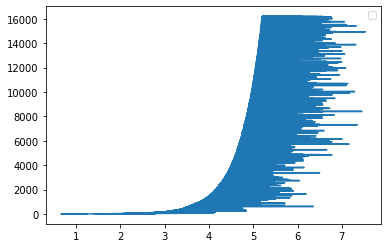

In [34]:
arrival_rate = 3.5
arrival_distribution = sts.expon(scale=1/arrival_rate)
next_arrival_time = arrival_distribution.rvs() 
service_det_time = 0.2

run_simulation(arrival_rate, service_det_time, 5 )


## reflection
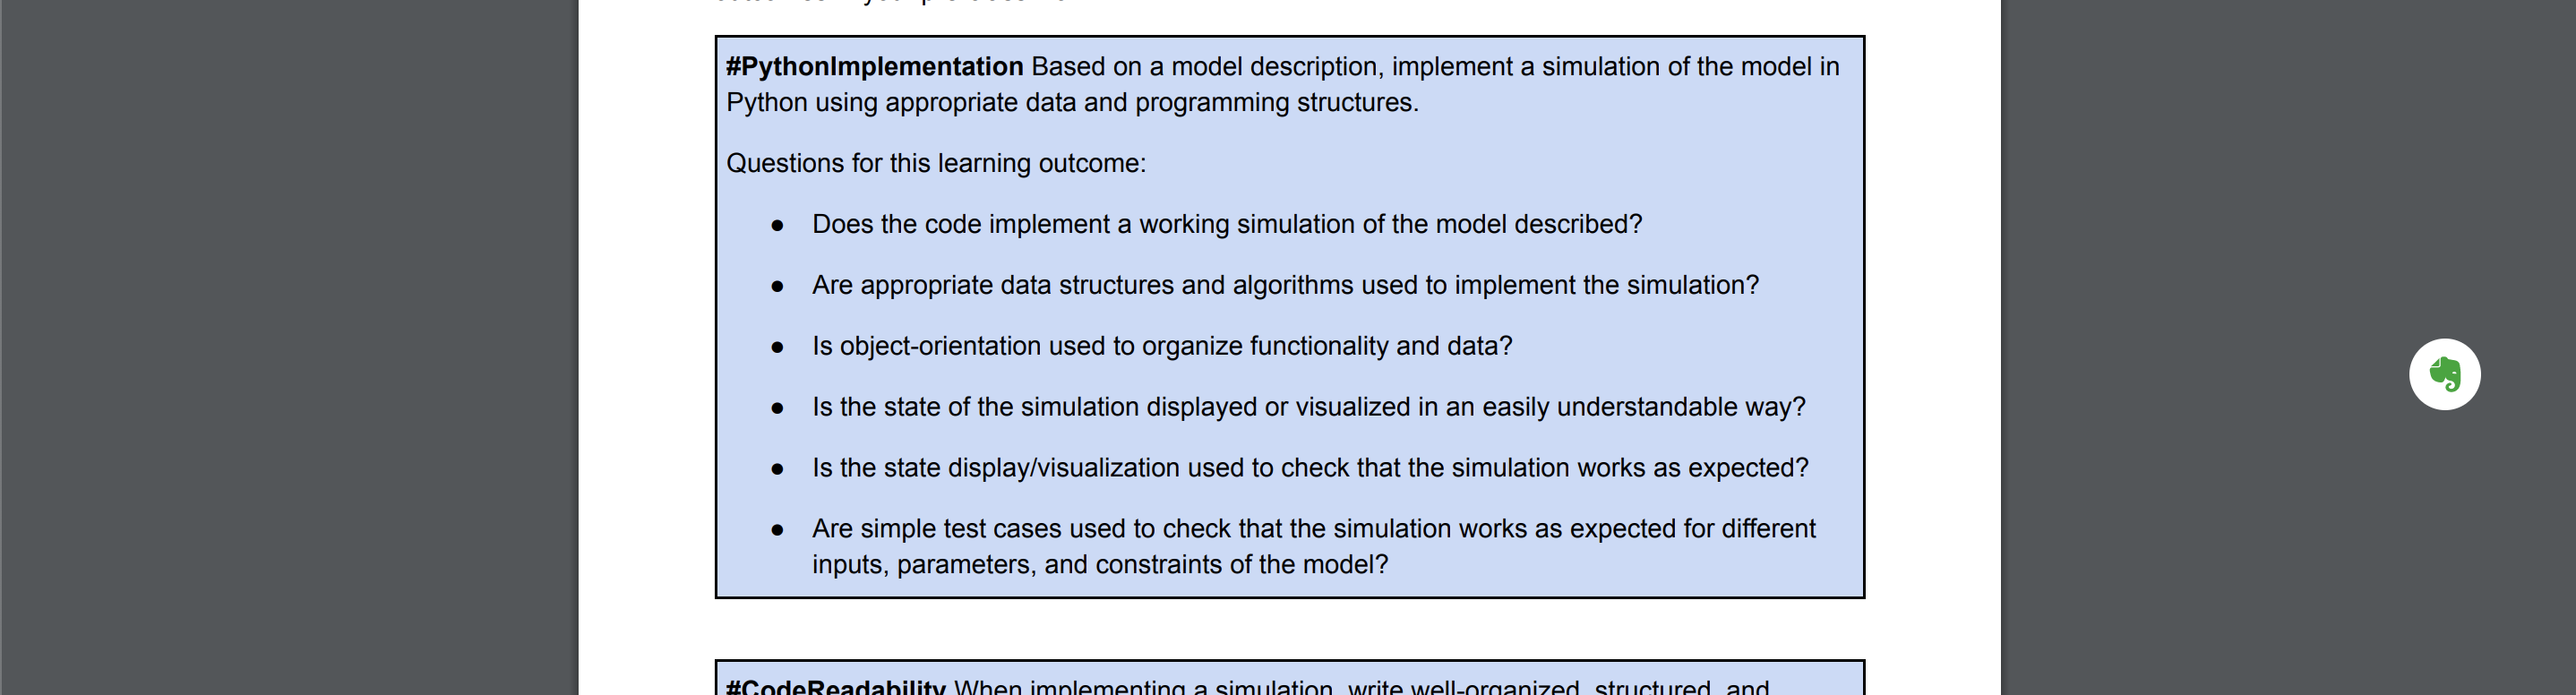

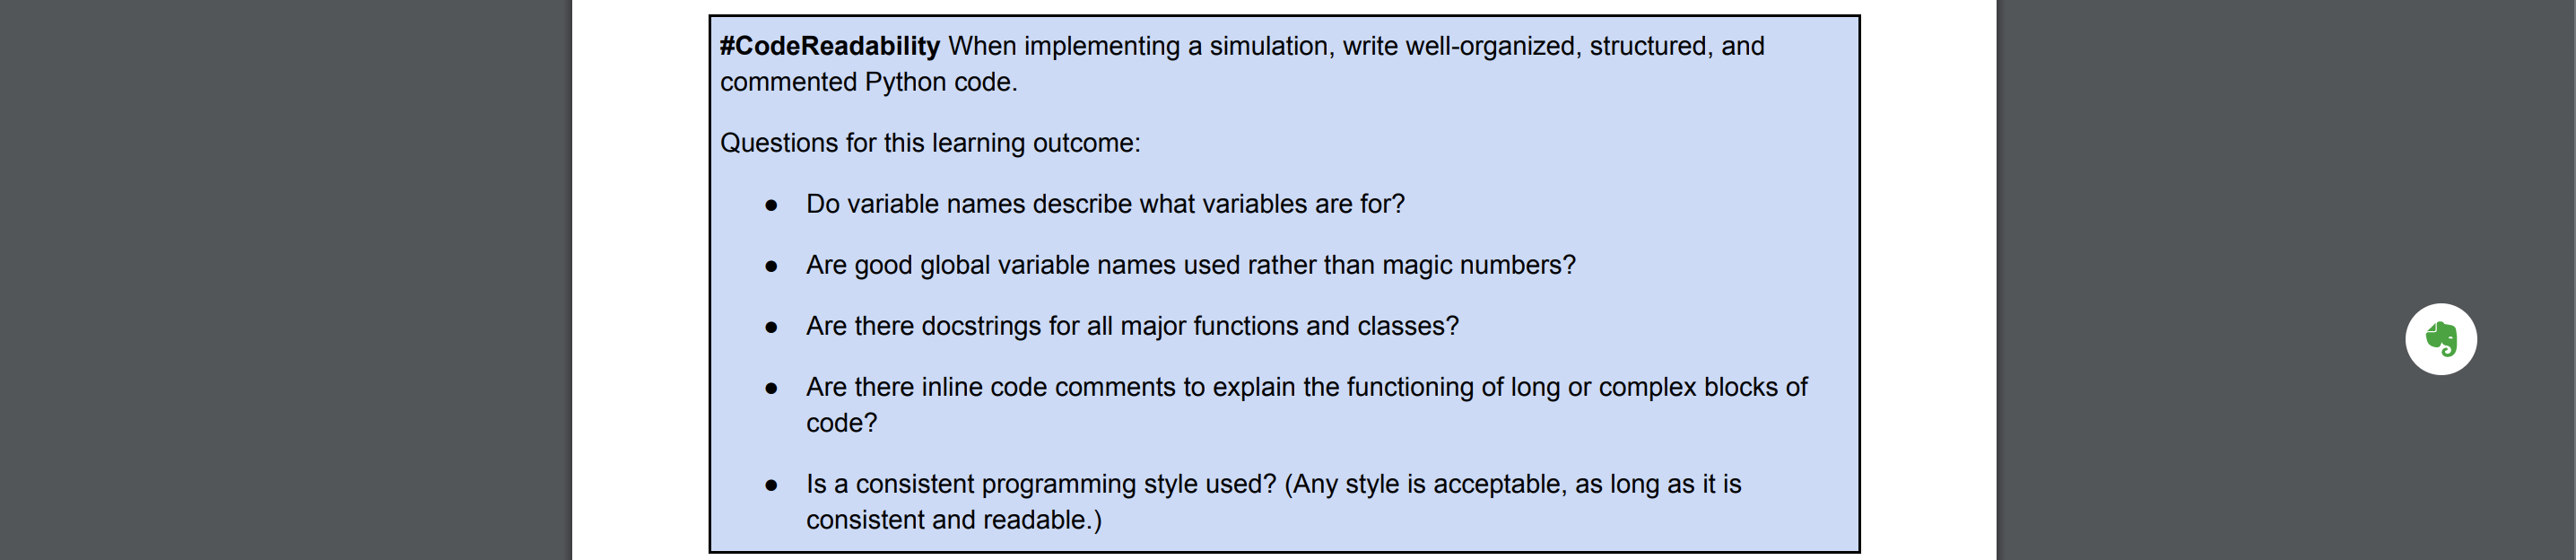

- My code *does* provide a working simulation, but it does have a bug (as explained un the first cell). Queue data structure is used and I can argue that it is appropriate given the nature of given scenario -- that is FIFO waiting line in the supermarket. OOP is used. The vizualization is provided (but without axis titles:( ).
-  I clearly commented my whole code and even provided a note explaining and guessing why code is not working. All functions defined by me include description (docstring) of them so are classes. Variable names have a huigh explnantory power suggesting a user what the variable is storing (eg `num_in_queue` or `fixed_serve_rate`). Furthermore, I followed all Python conventions for variable naming. 
- 

# PROFESSOR'S TUTORIAL: The Event and Schedule classes
[video](https://www.loom.com/share/66933a6644ec4b41b04b28dbf07d43ae)

You should copy this code into your own Python notebook and use it to complete your pre-class work.

In [4]:
import heapq
schedule = []
heapq.heappush(schedule, 5)
heapq.heappush(schedule, 10)
heapq.heappush(schedule, 1)
heapq.heappush(schedule, 7)

In [6]:
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function # will be a function taht we want to run when the event is triggered like serving a customer
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        # Return the time of the next event. The `now` attribute of this class
        # contain the time of the last event that was run.
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        # Print out diagnostic information about the events in the schedule.
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

## A simple test of the schedule

You do not need this code for your pre-class work. It demonstrates that the schedule can add and run events.

In [7]:
def print_and_add(schedule, string):
    print(f'At time {schedule.now}:', string)
    schedule.add_event_after(0.25, print_and_add, 'Another event')
            
schedule = Schedule()
schedule.print_events()

schedule.add_event_at(0.5, print_and_add, 'First event')
schedule.add_event_at(1.2, print_and_add, 'Second event')
schedule.print_events()

schedule.run_next_event()
schedule.print_events()

schedule.run_next_event()
schedule.print_events()

schedule.run_next_event()
schedule.print_events()

Schedule() at time 0 with 0 events in the queue
Schedule() at time 0 with 2 events in the queue
   0.5: print_and_add
   1.2: print_and_add
At time 0.5: First event
Schedule() at time 0.5 with 2 events in the queue
   0.75: print_and_add
   1.2: print_and_add
At time 0.75: Another event
Schedule() at time 0.75 with 2 events in the queue
   1.0: print_and_add
   1.2: print_and_add
At time 1.0: Another event
Schedule() at time 1.0 with 2 events in the queue
   1.2: print_and_add
   1.25: print_and_add


# The cuckoo clock simulation

You do not need this code for your pre-class work but you can use it as a starting point for implementing your queue simulation.

In [3]:
class Cuckoo:
    def __init__(self, interval):
        self.interval = interval
        self.hour = 0
    
    def make_some_noise(self, schedule):
        self.hour += 1
        print('Cuckoo! ' * self.hour)
        if self.hour == 12:
            self.hour = 0

class Pendulum:
    def __init__(self, cuckoo):
        self.cuckoo = cuckoo
    
    def tick(self, schedule, counter):
        counter += 1
        print(f'tick {counter} at time = {schedule.now}')
        schedule.add_event_after(0.5, self.tock, counter)
        
    def tock(self, schedule, counter):
        print(f'tock {counter} at time = {schedule.now}')
        schedule.add_event_after(0.5, self.tick, counter)
        if counter % self.cuckoo.interval == 0:
            schedule.add_event_after(0, self.cuckoo.make_some_noise)

class Clock:
    def __init__(self):
        self.cuckoo = Cuckoo(interval=5)
        self.pendulum = Pendulum(self.cuckoo)
    
    def run(self, schedule):
        schedule.add_event_at(0.5, self.pendulum.tick, counter=0)

def run_simulation(run_until):
    schedule = Schedule()
    clock = Clock()
    clock.run(schedule)
    while schedule.next_event_time() <= run_until:
        schedule.run_next_event()

In [4]:
run_simulation(run_until=10)

tick 1 at time = 0.5
tock 1 at time = 1.0
tick 2 at time = 1.5
tock 2 at time = 2.0
tick 3 at time = 2.5
tock 3 at time = 3.0
tick 4 at time = 3.5
tock 4 at time = 4.0
tick 5 at time = 4.5
tock 5 at time = 5.0
Cuckoo! 
tick 6 at time = 5.5
tock 6 at time = 6.0
tick 7 at time = 6.5
tock 7 at time = 7.0
tick 8 at time = 7.5
tock 8 at time = 8.0
tick 9 at time = 8.5
tock 9 at time = 9.0
tick 10 at time = 9.5
tock 10 at time = 10.0
Cuckoo! Cuckoo! 
